# Data analysis
## Exploratory Data Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/home/kliton/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


First, we load the data from logins.json to a pandas dataframe:

In [2]:
Data = pd.read_json("logins.json")

Next, we check the data format in the table (dataframe) by taking the first 5 rows:

In [3]:
Data.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

A new column is created ('Count'). This column is set to all 1s as for each timestamp there is 1 data point:

In [4]:
Data.loc[:, 'Count'] = 1

A time series is by definition a set of features indexed by a timestamps. Adding the timestamp to the dataframe:

In [5]:
Data = Data.set_index('login_time')

The aggregated record count for 15 minutes interval is visualized in: 

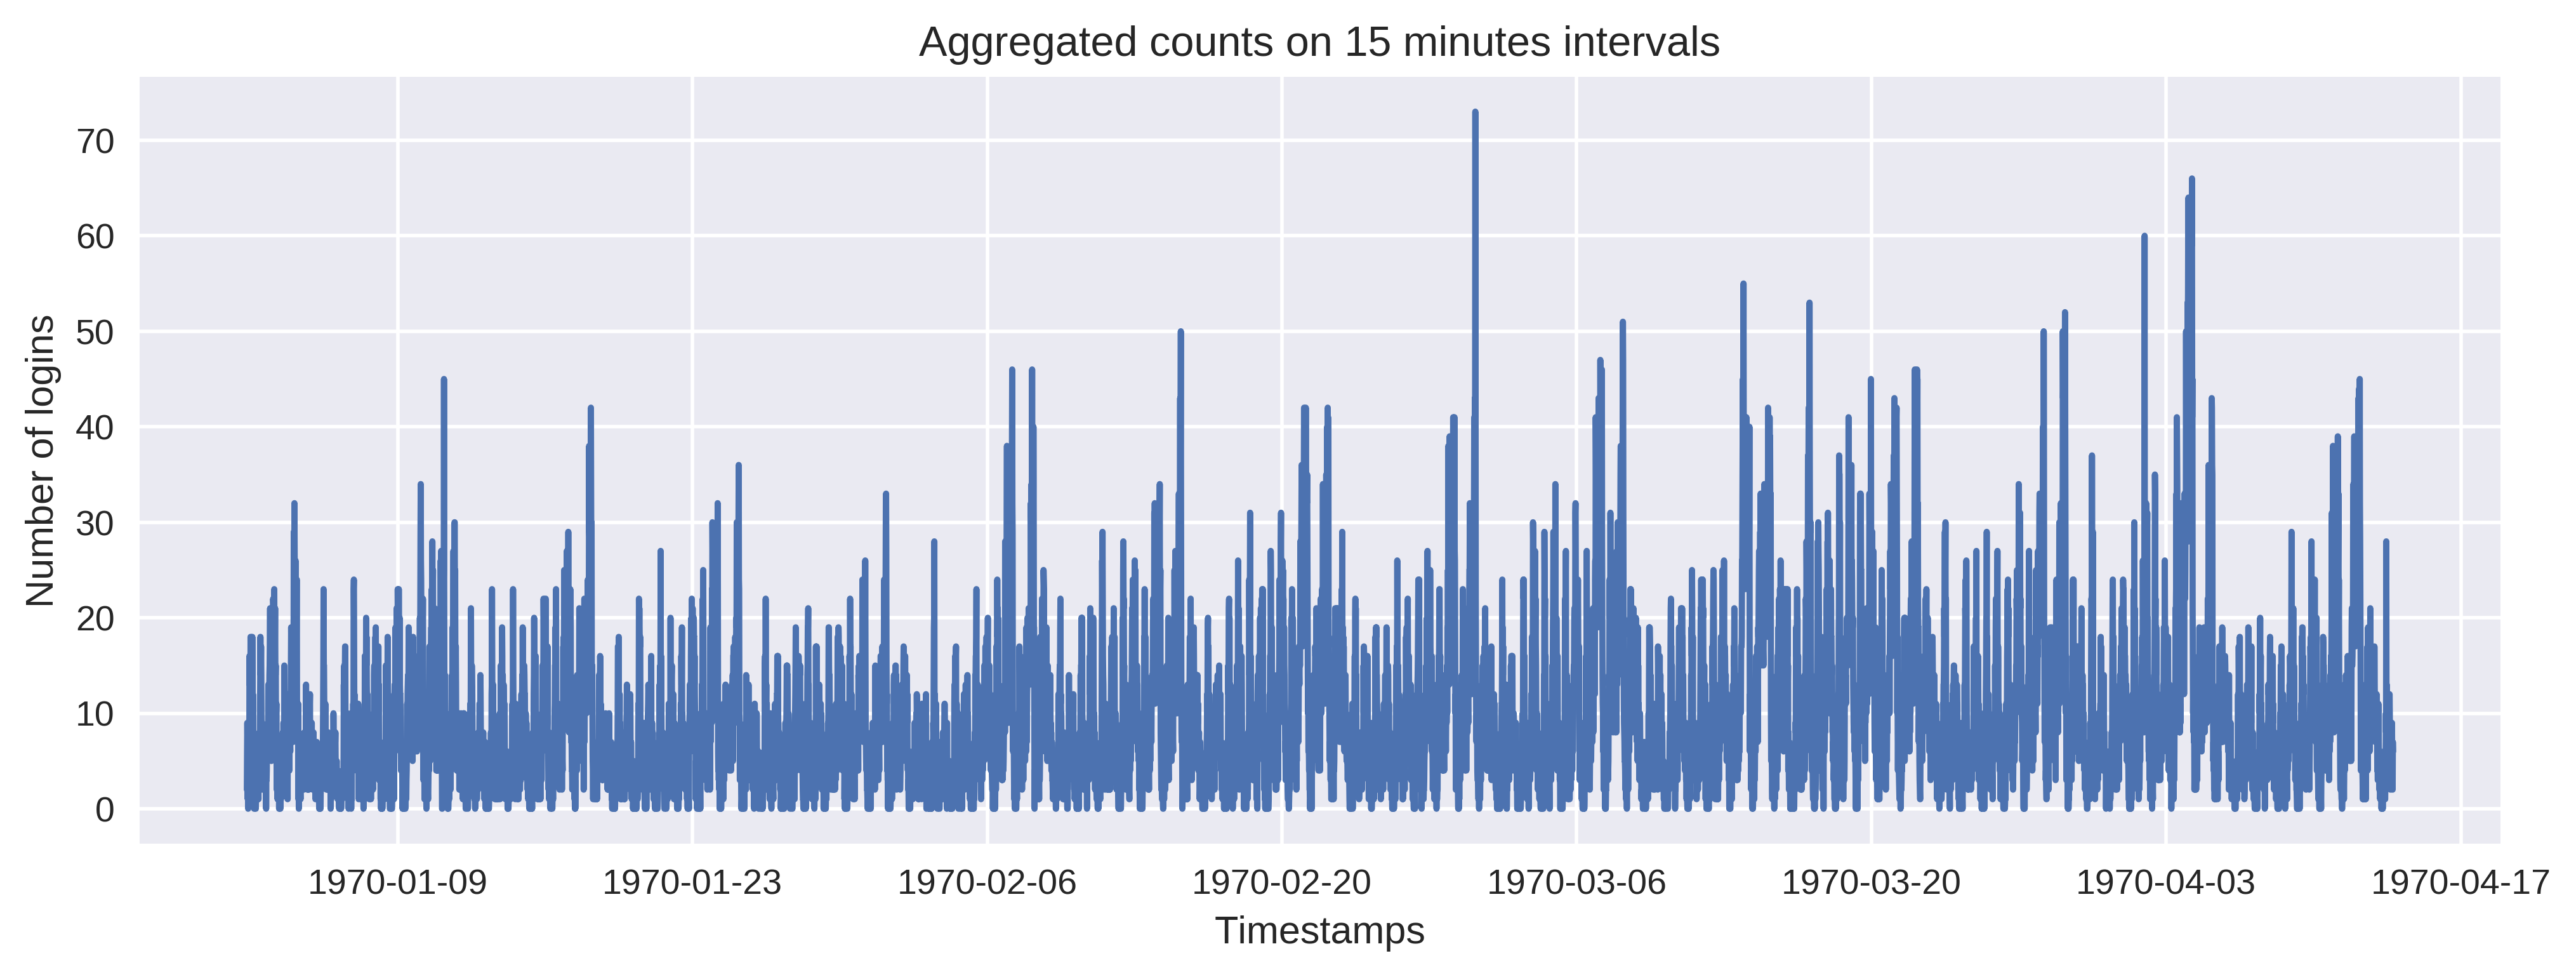

In [13]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Aggregated counts on 15 minutes intervals", 
                       xlabel= "Timestamps",
                       ylabel= "Number of logins")
axes.plot(Data.resample('15Min').count());
plt.show();

We see there are some values much higher than others which suppress the details for other lower values because of scaling. This effect could be mitigated by transforming to a logarithmic scale:

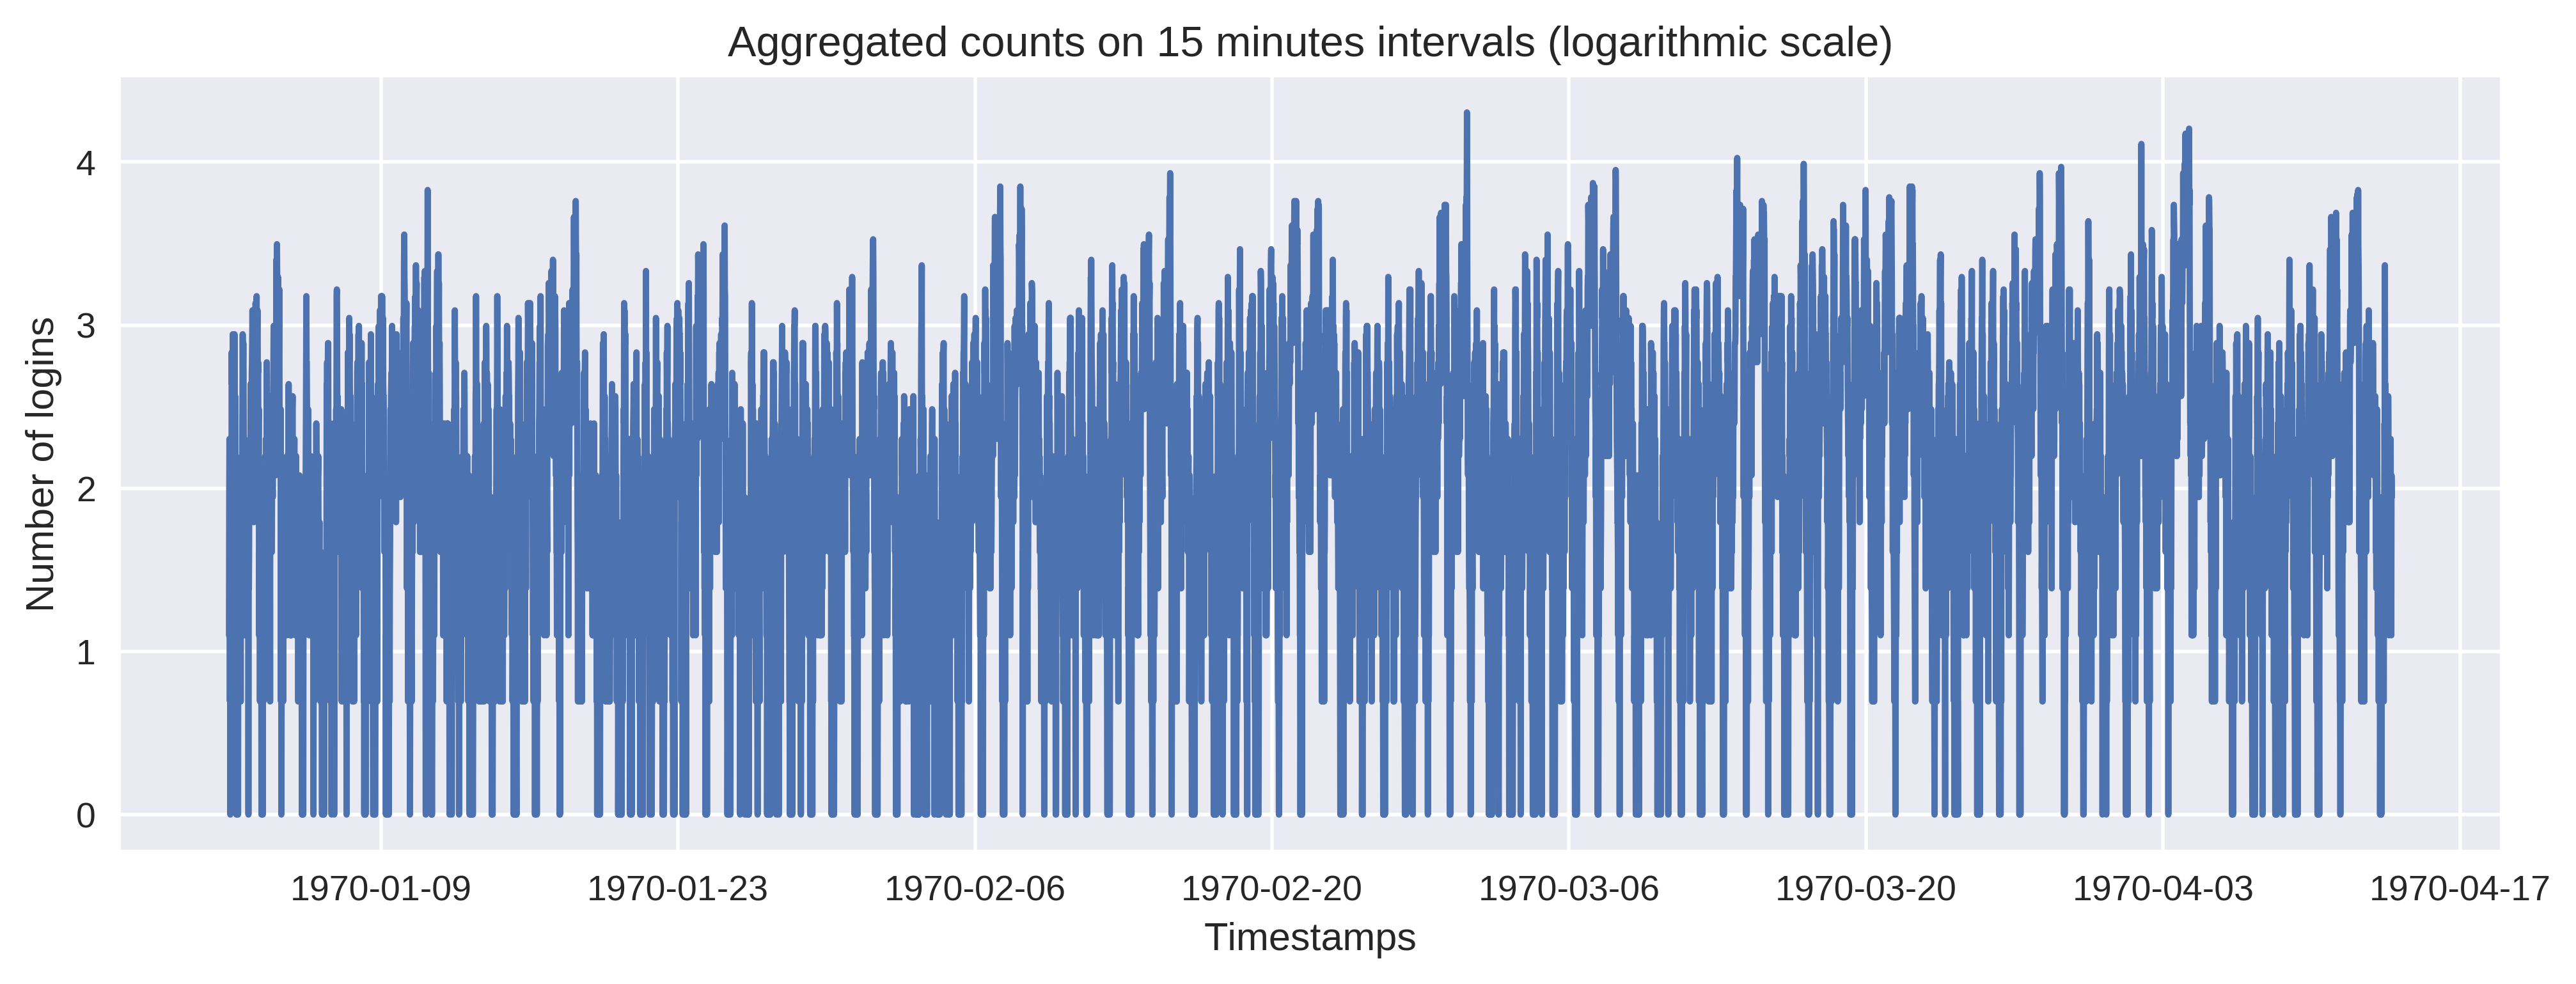

In [14]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Aggregated counts on 15 minutes intervals (logarithmic scale)", 
                       xlabel= "Timestamps",
                       ylabel= "Number of logins")
axes.plot(Data.resample('15Min').count().apply(np.log1p))
plt.show();

There are too many data points on the abscissa (x-axis). Let's zoom to a number of days:

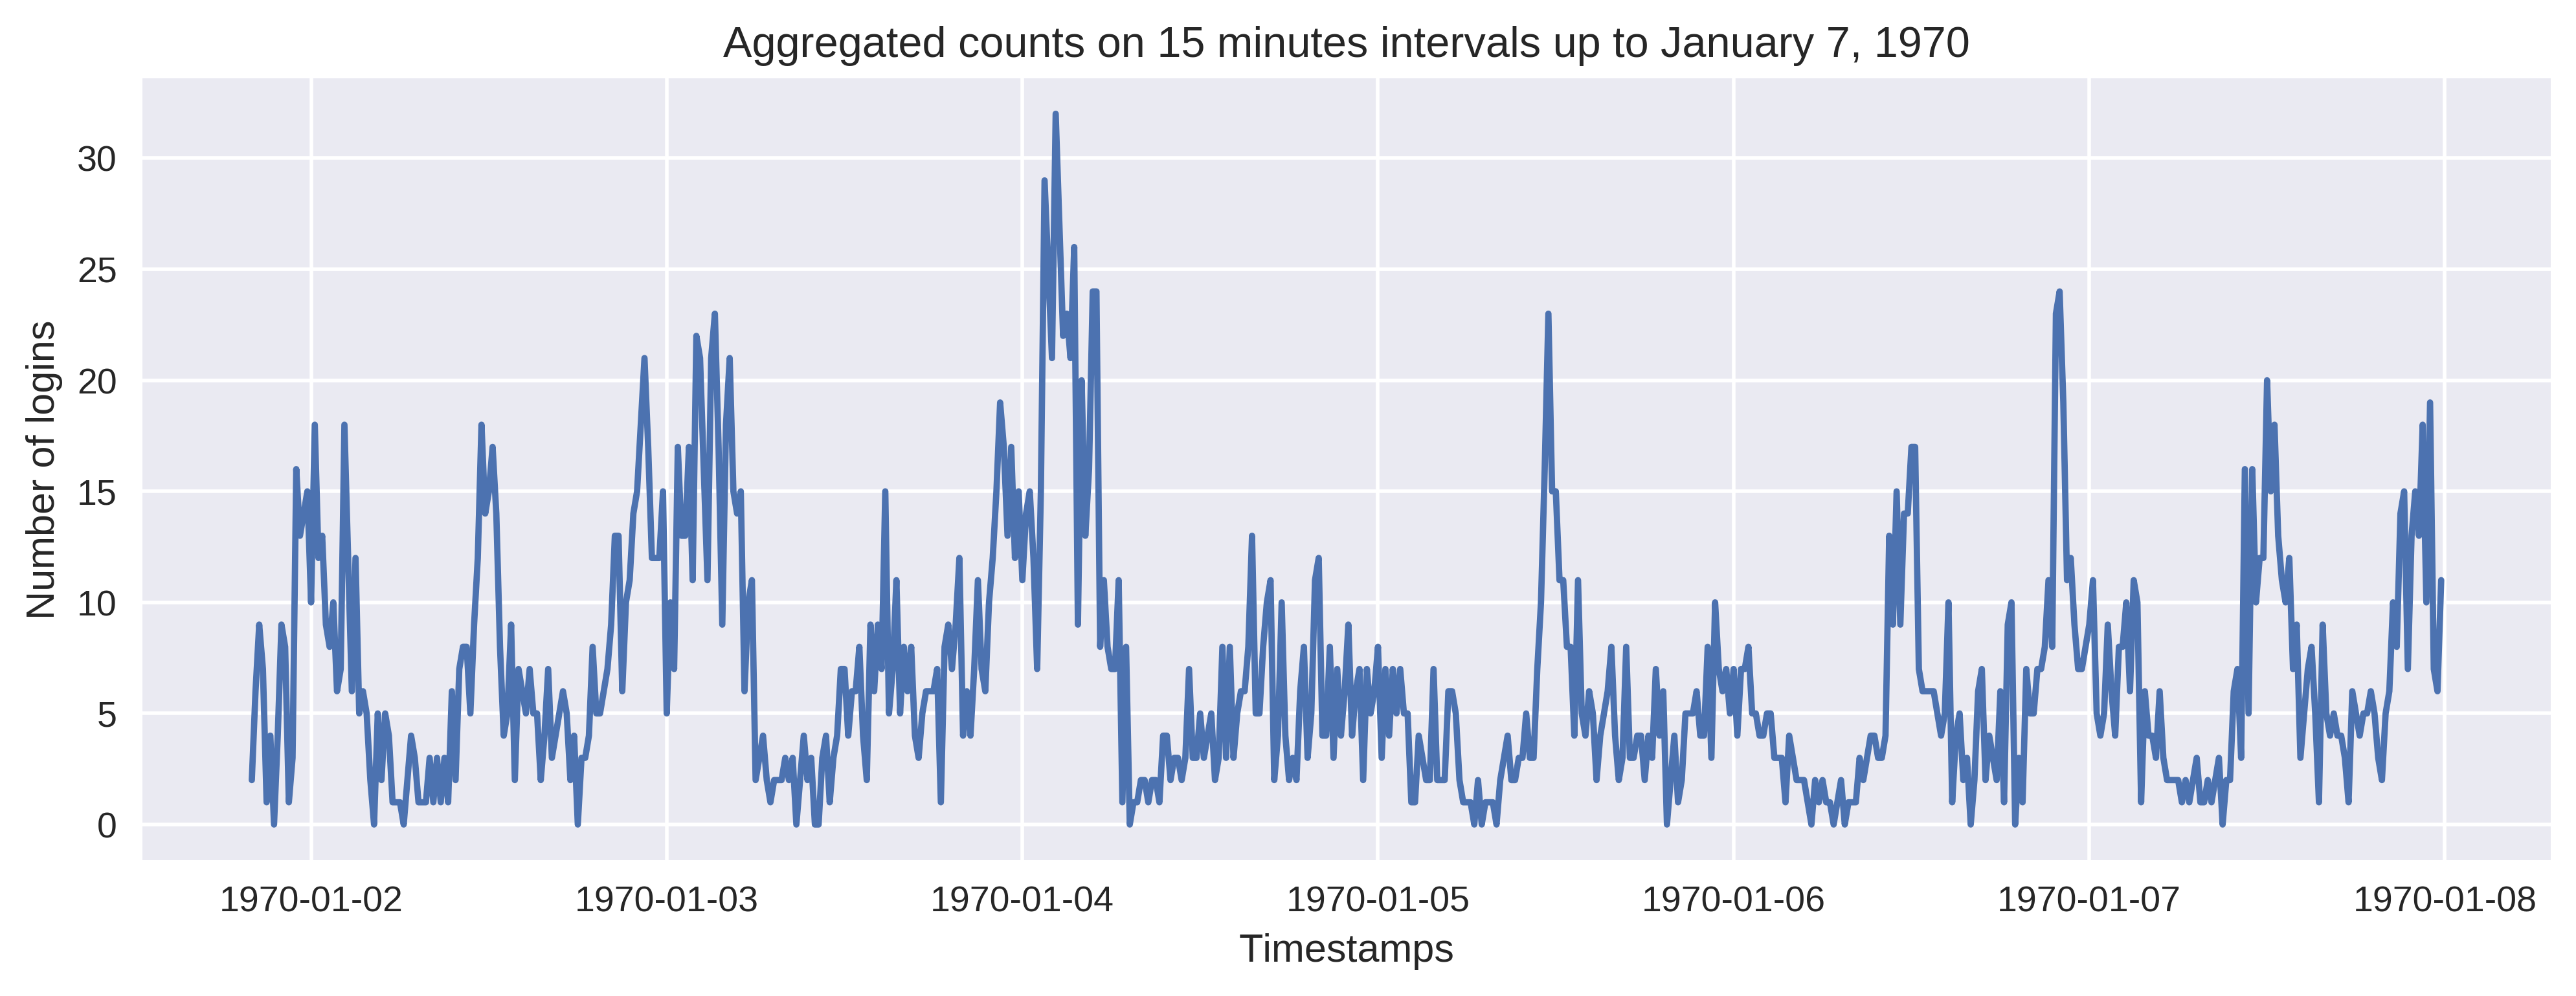

In [15]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Aggregated counts on 15 minutes intervals up to January 7, 1970", 
                       xlabel= "Timestamps",
                       ylabel= "Number of logins")
axes.plot(Data.resample('15Min').count()[:'1970-01-07'])
plt.show();

There is no consistent pattern for the subsequent daily values plotted above.

To simplify the notation let's create a new dataframe with aggregated data:

In [16]:
TW15MinData = Data.resample('15Min').count()

Let's explore the values for the aggregated data by looking at the histogram:

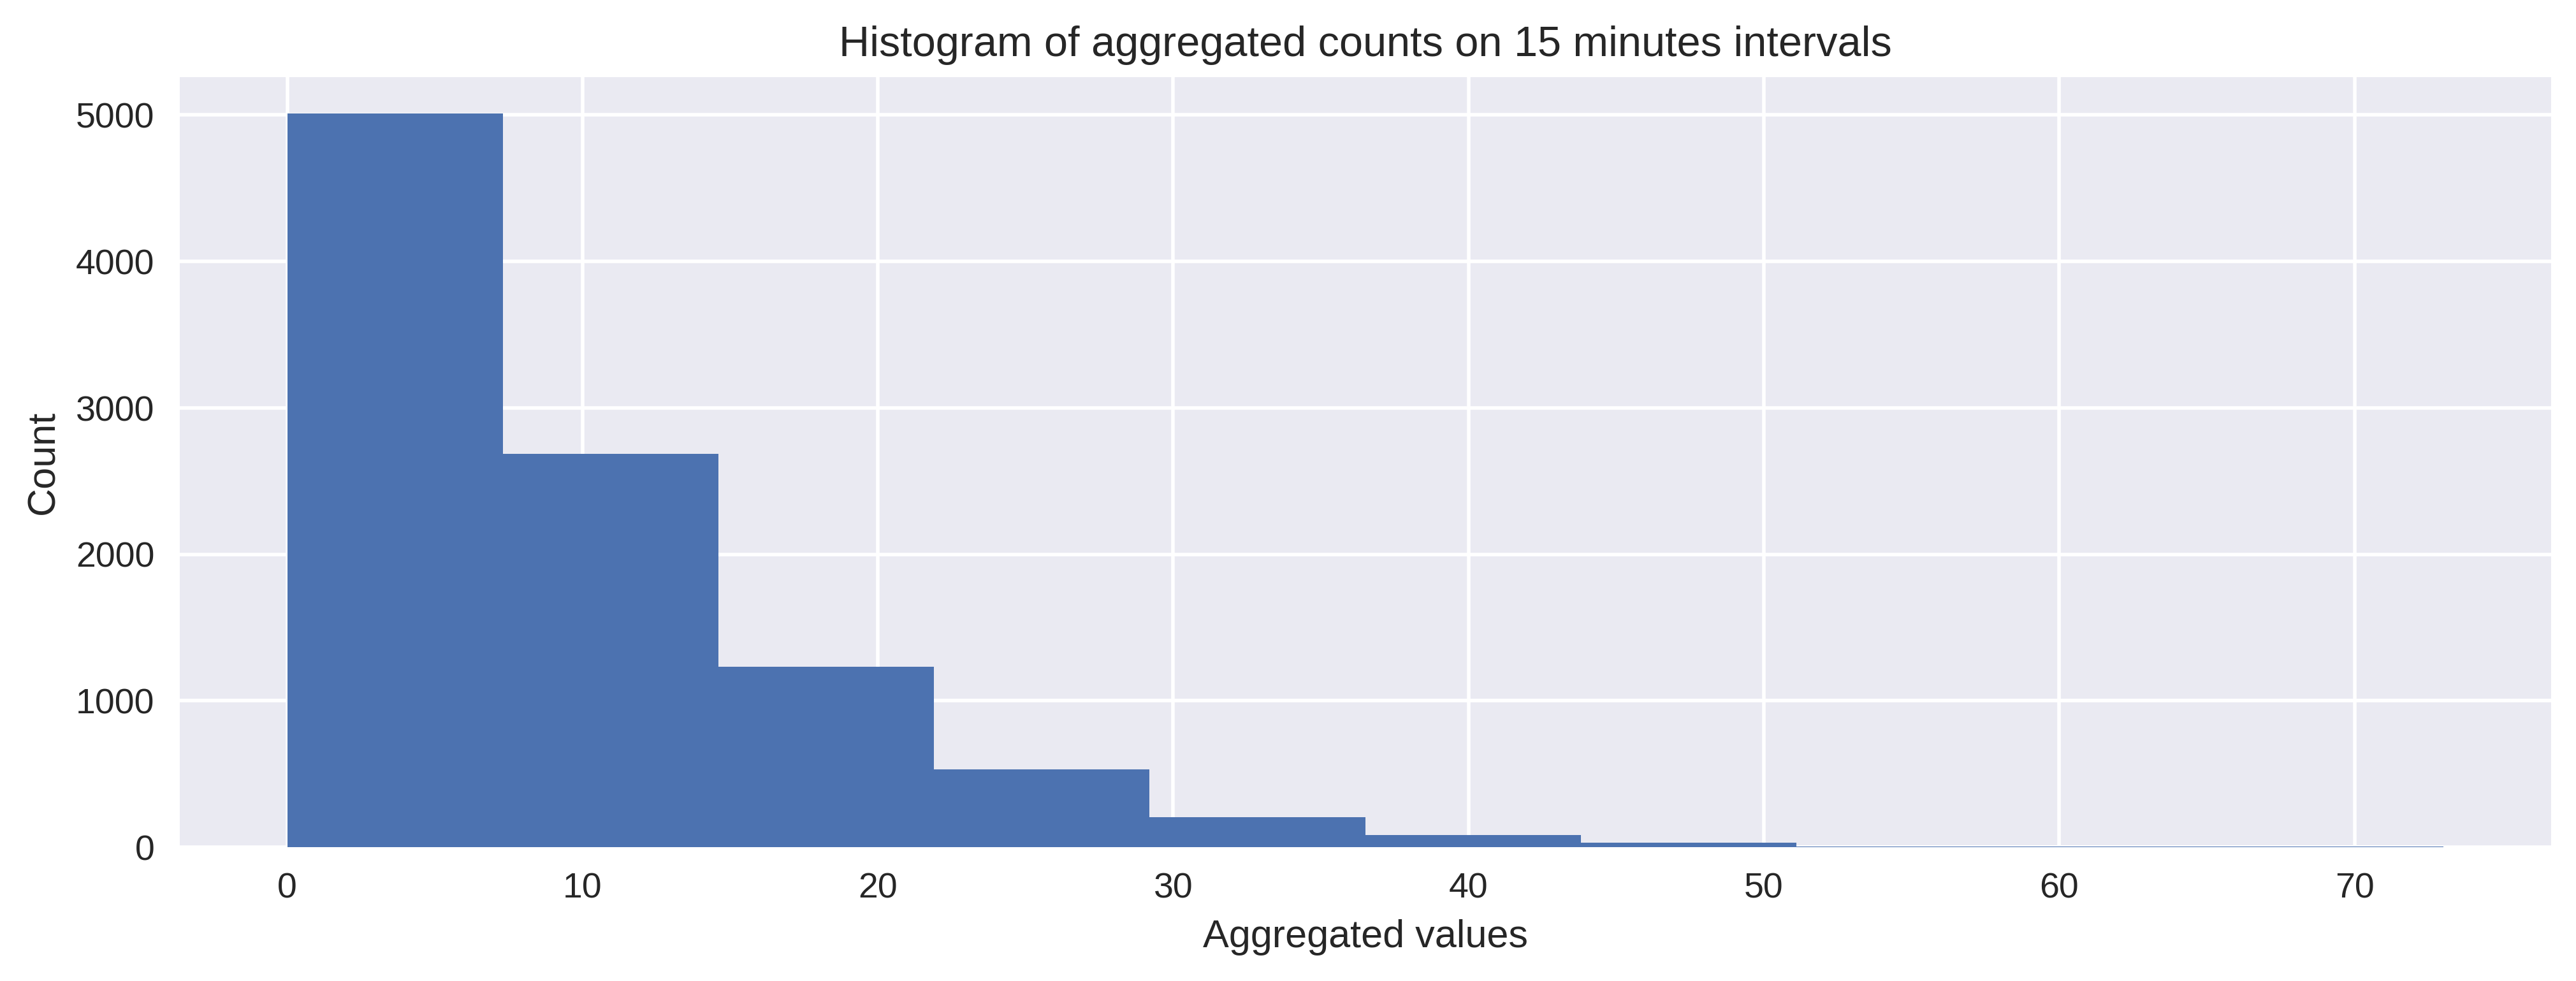

In [35]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Histogram of aggregated counts on 15 minutes intervals", 
                       xlabel= "Aggregated values",
                       ylabel= "Count")
TW15MinData.Count.hist(ax=axes);

Again there are value counts closer to 70 that are not visible. Applying logarithmic transformation on y-axis will enable us to identify those values:

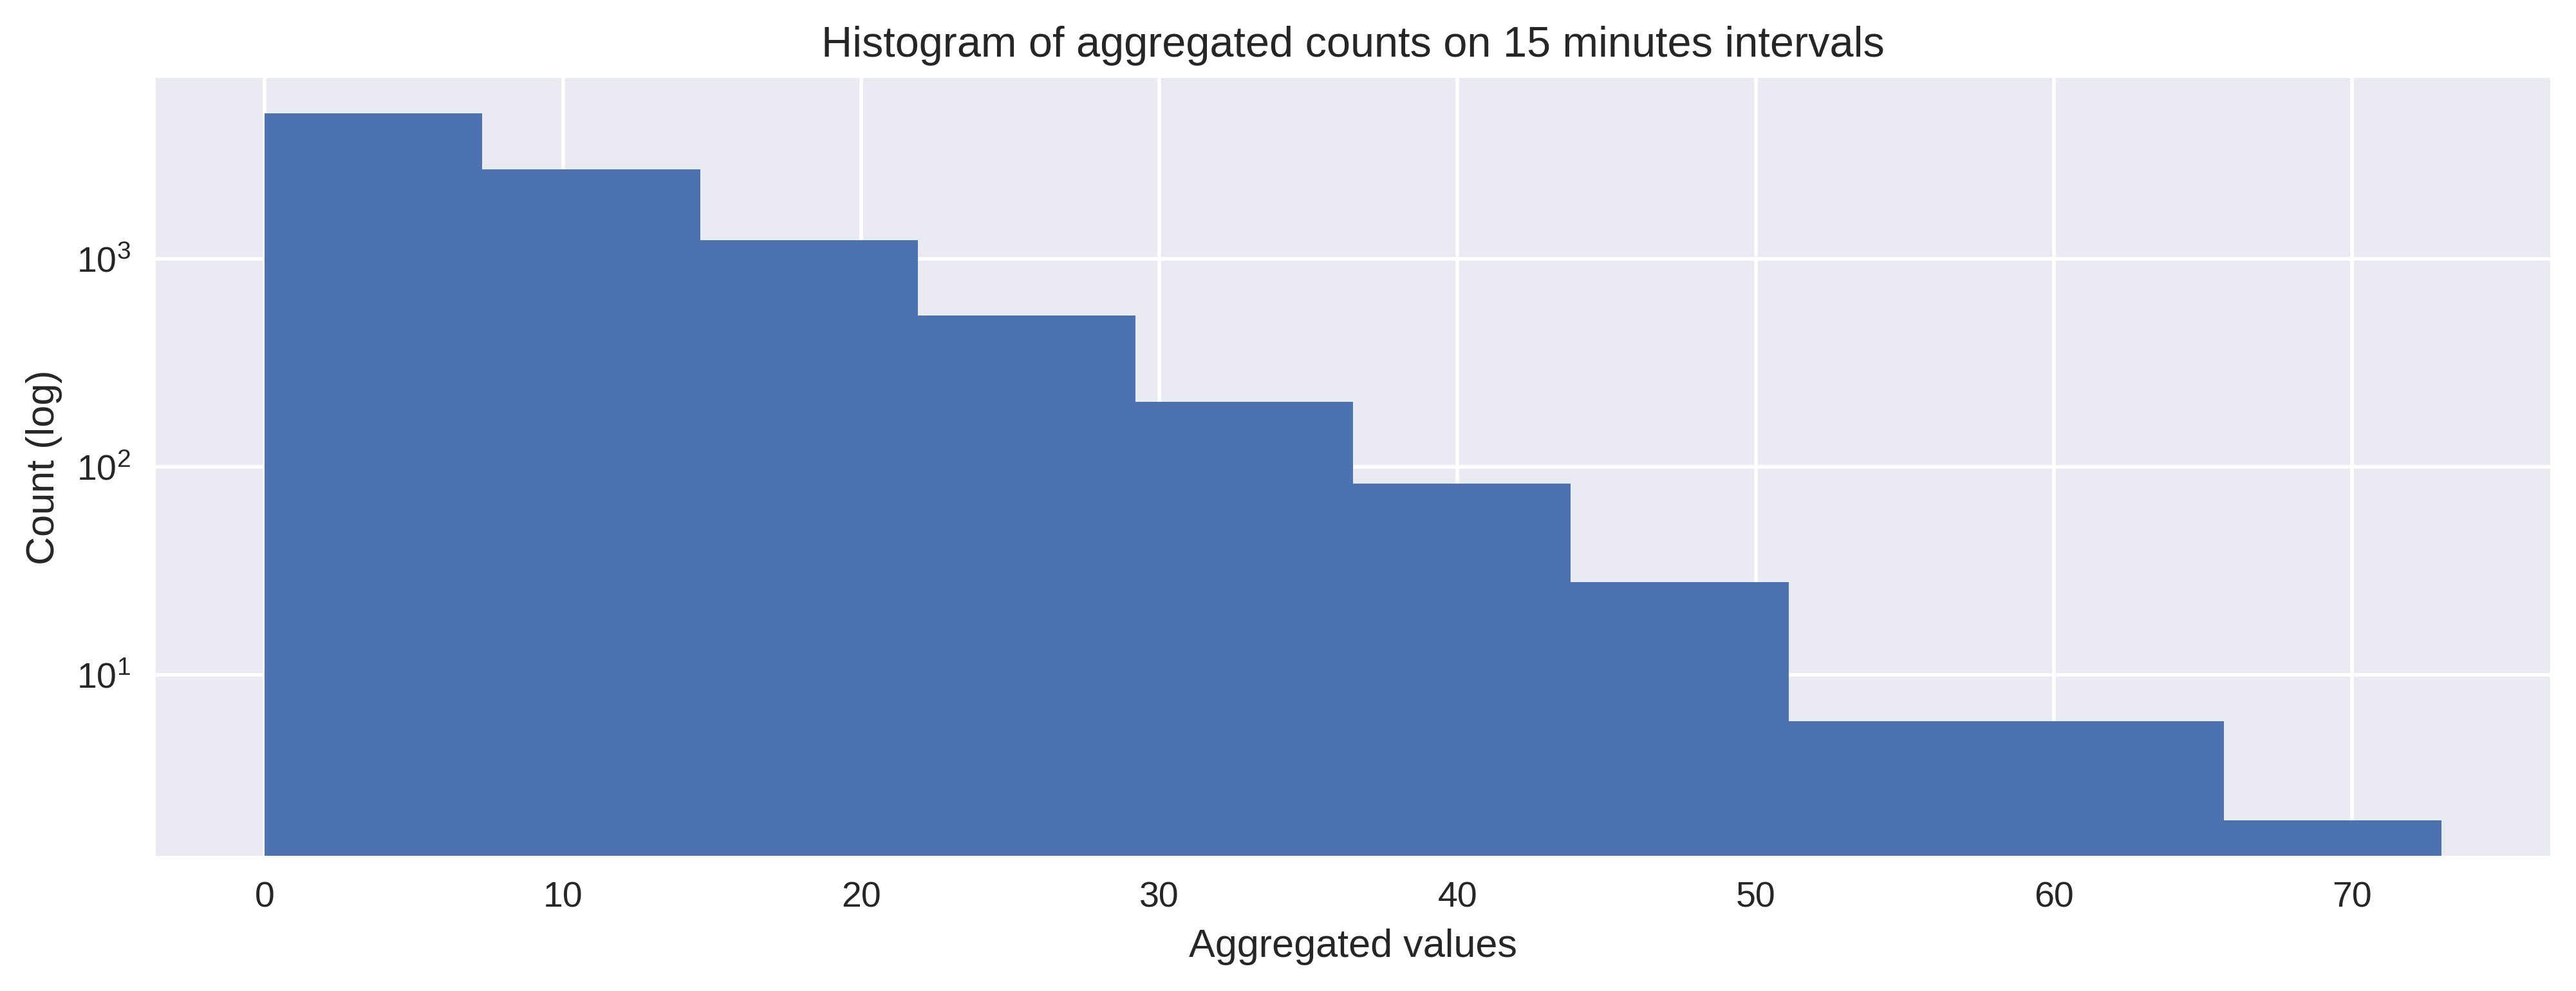

In [37]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes1 = fig.add_subplot(111, title="Histogram of aggregated counts on 15 minutes intervals", 
                       xlabel= "Aggregated values",
                       ylabel= "Count (log)")
TW15MinData.Count.hist(ax=axes1, log=True);

From the histogram we can see the value counts concentrated around 10 logins. A boxplot is a useful visualization tool to identify the mean (median) and tails of a distribution:

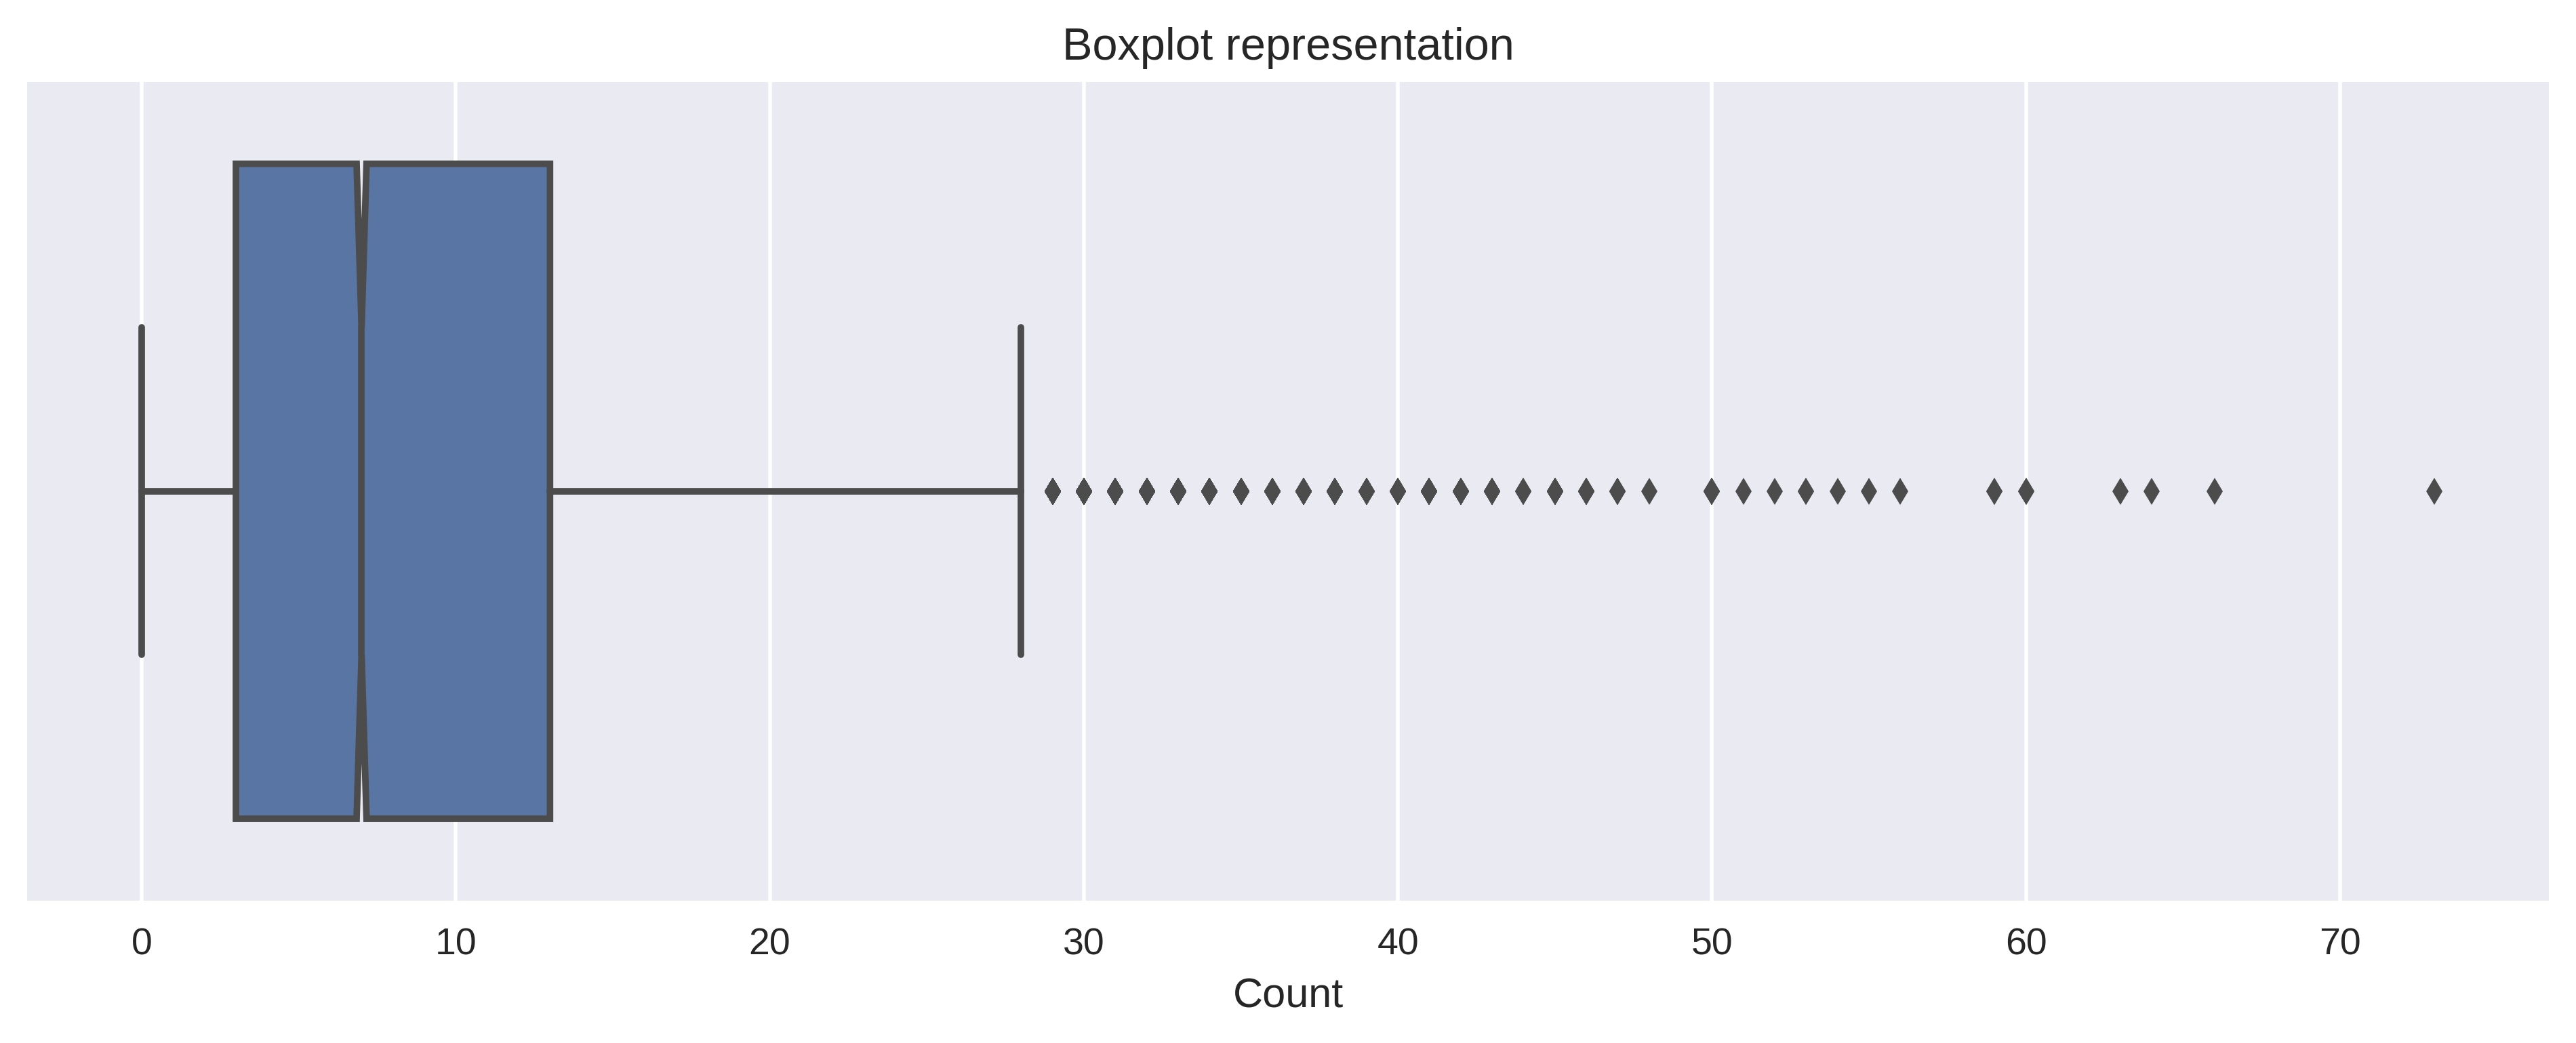

In [48]:
fig = plt.figure(figsize=(12,4), dpi=400)
bp = sns.boxplot(TW15MinData.Count, notch = True).set_title("Boxplot representation")
plt.show(bp);

The mean is located around 8-9 logins. However, boxplot assumes that the underlying distribution is symmetric (normal distribution).

Transforming the values to logarithmic scale we plot the following histogram:

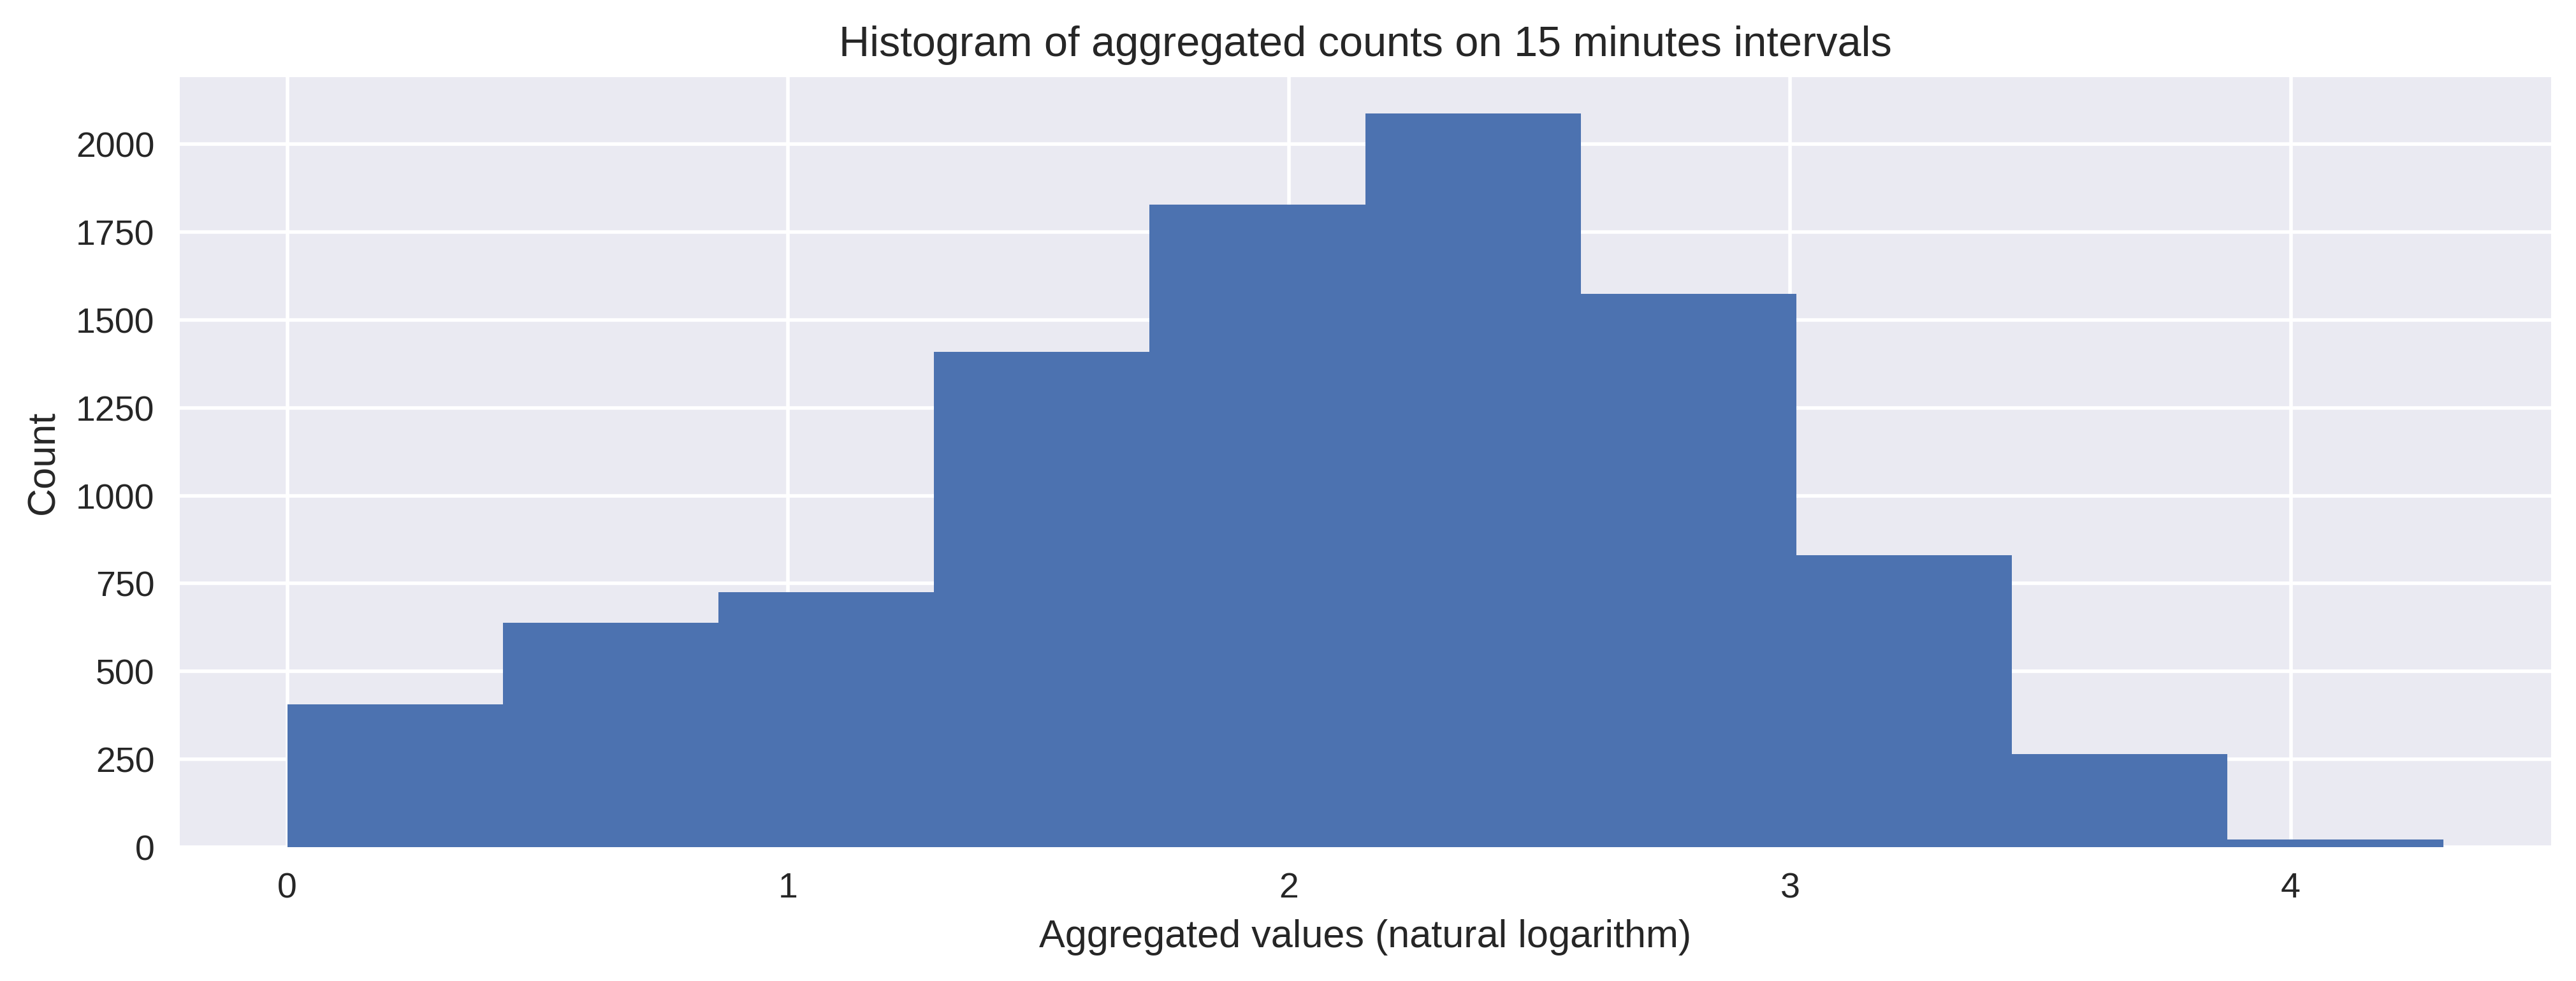

In [50]:
#TW15MinData.Count.apply(np.log1p).hist();
fig = plt.figure(figsize=(12,4), dpi=400)
axes1 = fig.add_subplot(111, title="Histogram of aggregated counts on 15 minutes intervals", 
                       xlabel= "Aggregated values (natural logarithm)",
                       ylabel= "Count")
TW15MinData.Count.apply(np.log1p).hist(ax=axes1);

This transformation results in a symmetric distribution of values. We can have a look at the boxplot representation of distribution:

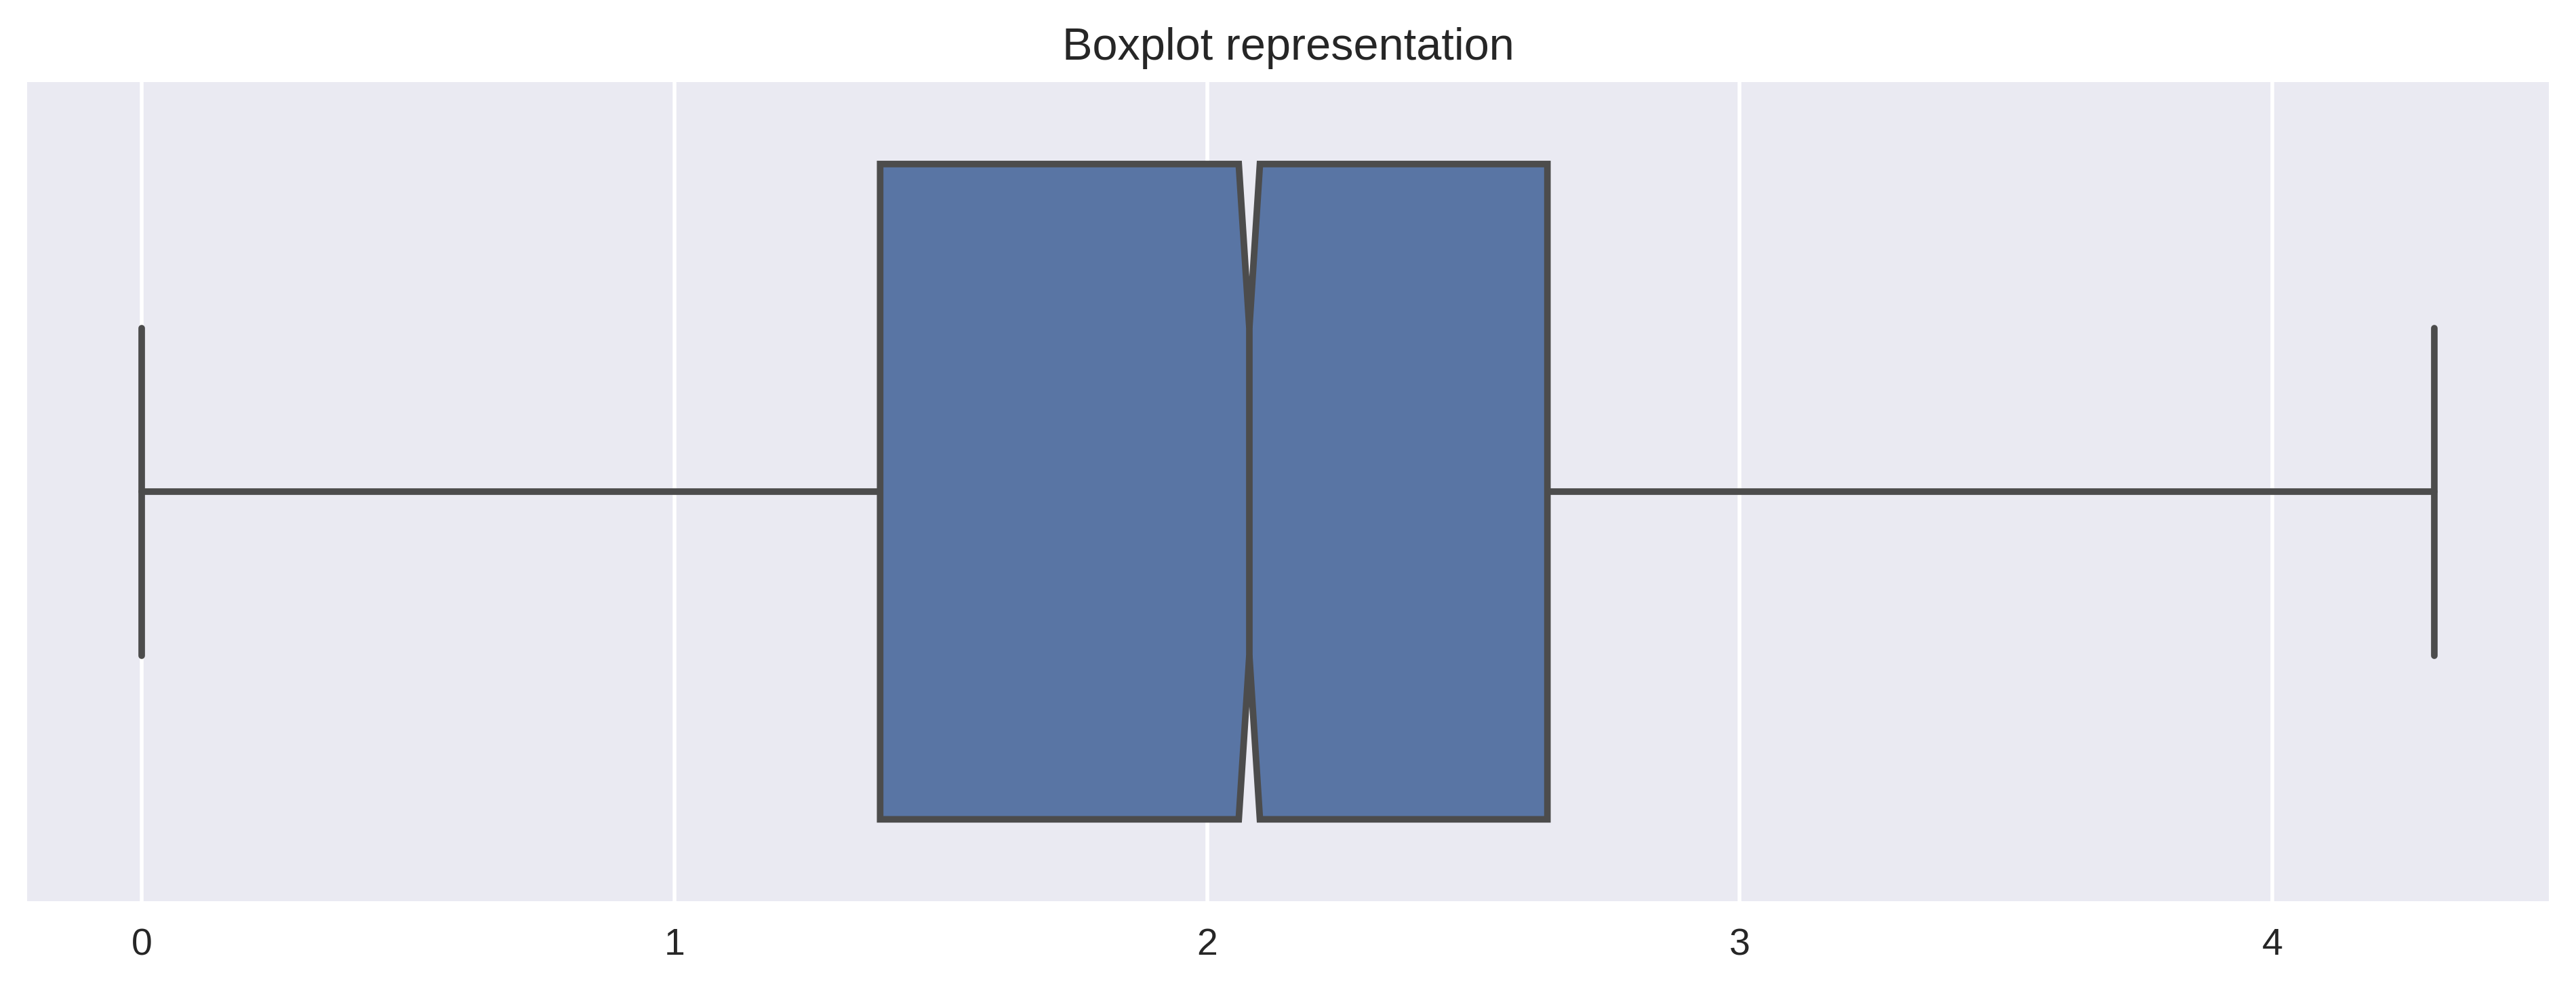

In [51]:
fig = plt.figure(figsize=(12,4), dpi=400)
bp = sns.boxplot(TW15MinData.apply(np.log1p).values, notch = True).set_title("Boxplot representation")
plt.show(bp);
#plt.boxplot(TW15MinData.apply(np.log1p).values, showmeans=True, notch=True, vert=False);

We have a symmetric distribution where no outlier are plotted. This transformation results to data which is much better to work with.

While working with time series it is common to transform the data to $y_t = x_t - x_{(t-1)}$. This transformation detrends the time series (if any trend is present) but also it's useful to further explore the nature of a time series.

The transformed time series looks like:

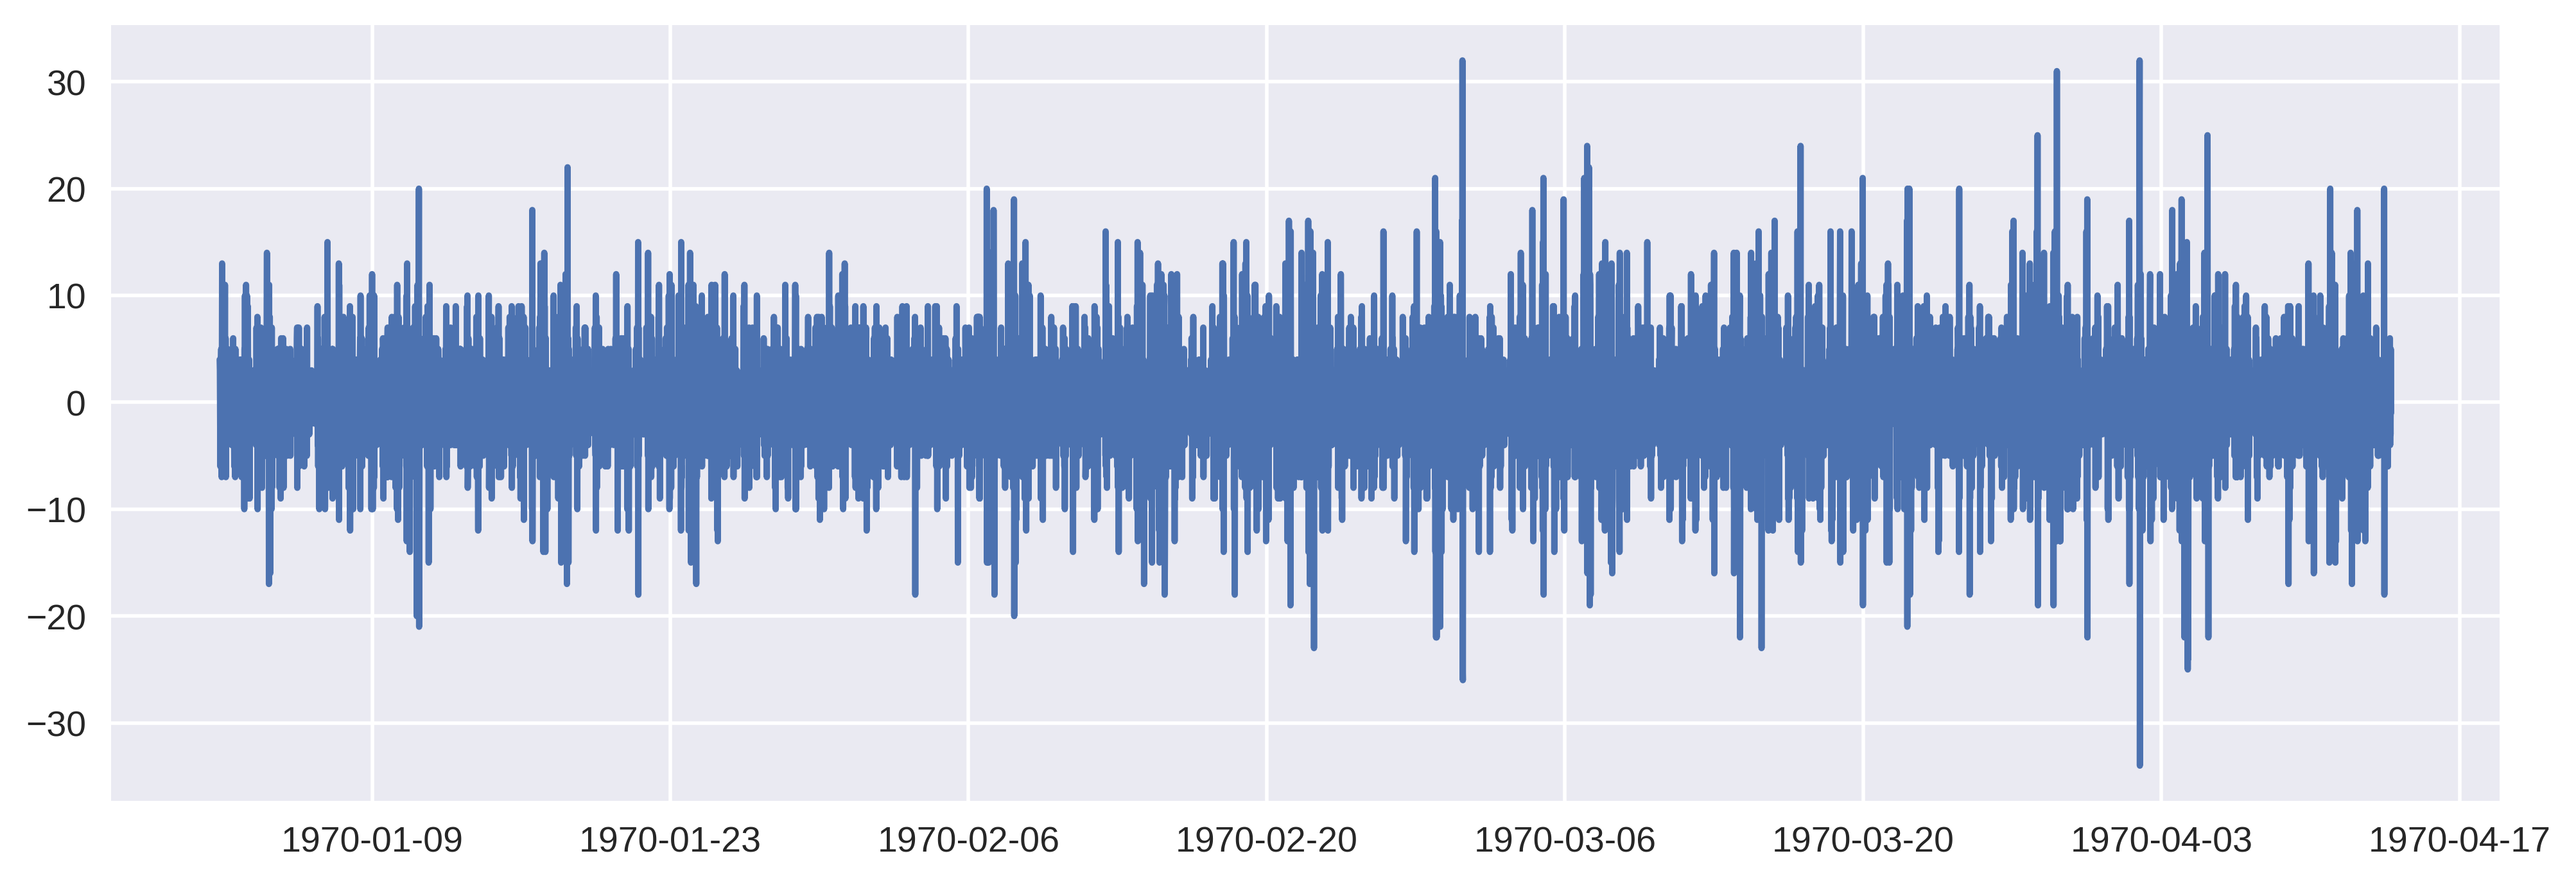

In [53]:
fig = plt.figure(figsize=(12,4), dpi=400)
plt.plot(TW15MinData.diff());

The values from the above plot are centered to 0 symmetrically. The histogram of the above values:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f898dd2c198>], dtype=object)

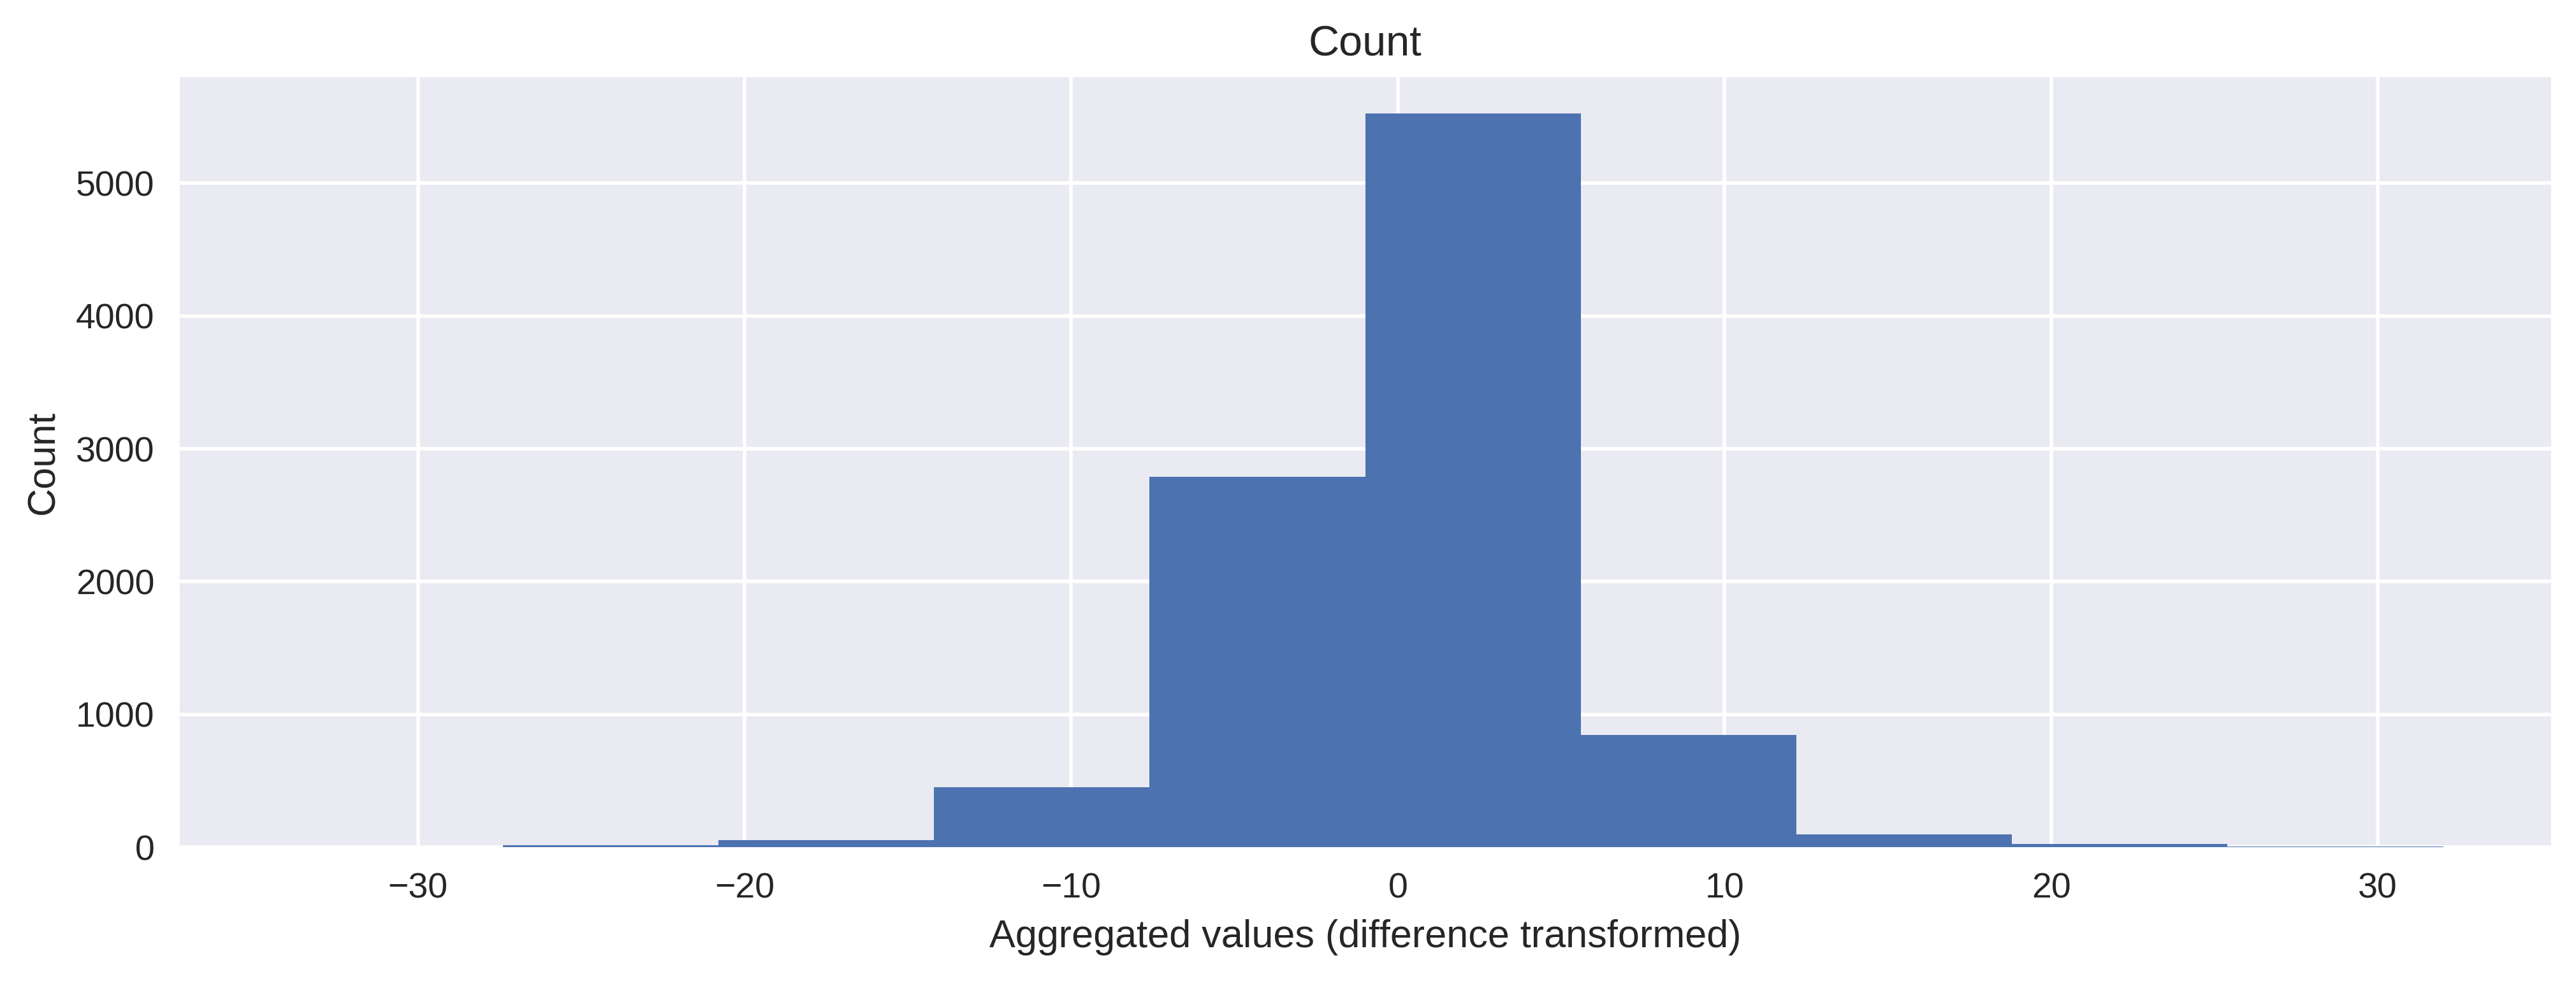

In [55]:
fig = plt.figure(figsize=(12,4), dpi=400)
axes = fig.add_subplot(111, title="Histogram of transformed time series (difference)", 
                       xlabel= "Aggregated values (difference transformed)",
                       ylabel= "Count")
TW15MinData.diff().hist(ax=axes)

The values are spread equally around 0. The difference of the subsequent values results in a symmetrical distribution as per the histogram plotted above.

The boxplot representation:

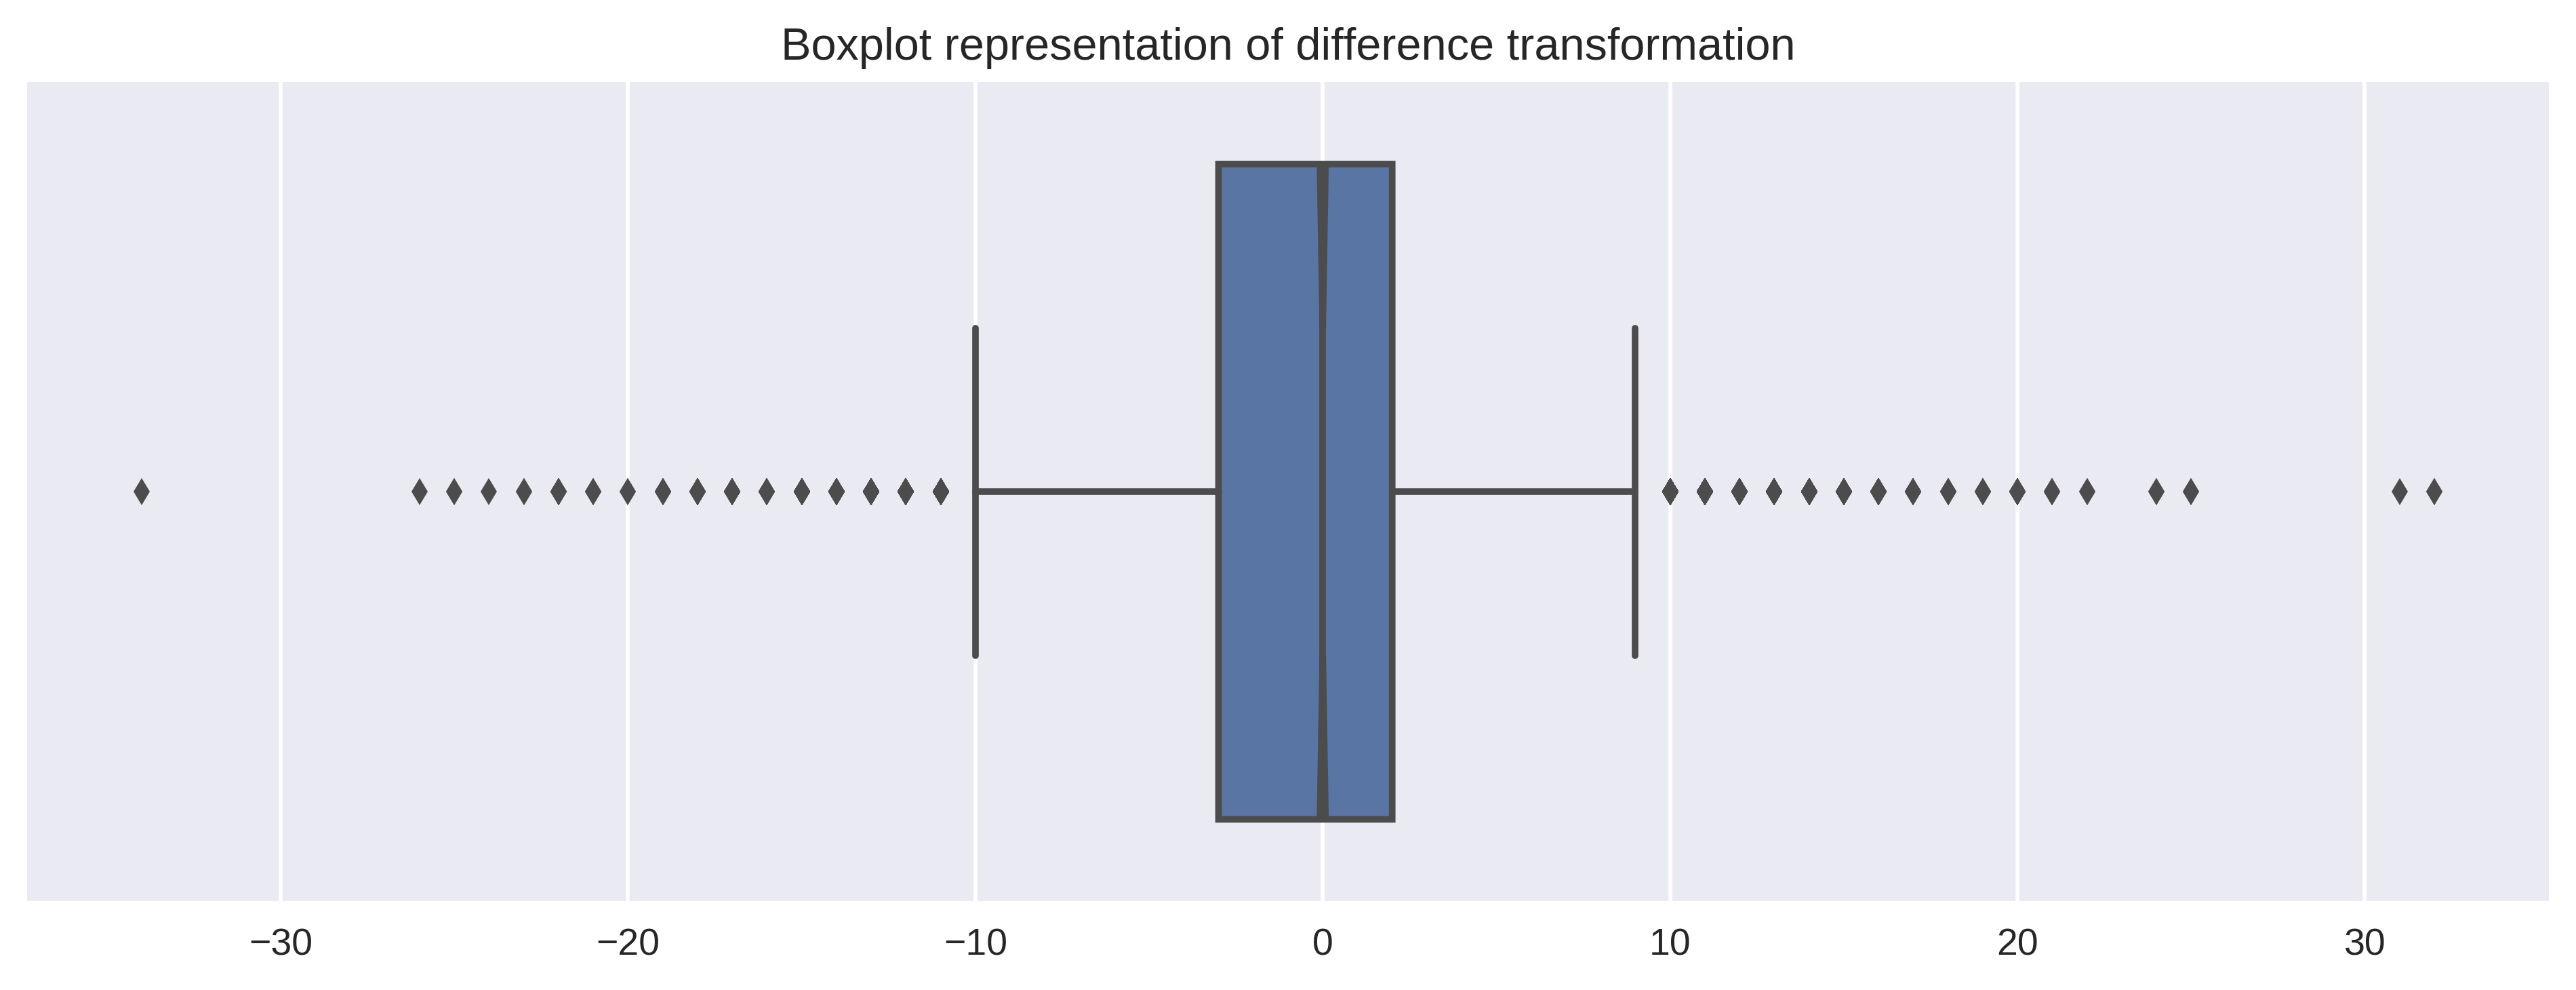

In [56]:
fig = plt.figure(figsize=(12,4), dpi=400)
bp = sns.boxplot(TW15MinData.diff()[1:].values, notch = True).set_title(
    "Boxplot representation of difference transformation")
plt.show(bp);

The above boxplot shows there are outliers in the underlying distribution.

Stationarity is one important property for time series. A stationary time series has the following properties:
  1. Mean is constant over time
  2. Standard deviation is constant over time
  3. Autocovariance is not a function of time

Dickey-Fuller test is the statistical test we apply to either reject or accept whether a time series is stationary. Null hypothesis claims that a time series is not stationary. Let's apply the test:

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(TW15MinData.Count)

In [18]:
print('ADF Statistic: %f' % adfuller_test[0])
print('p-value: %f' % adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.337954
p-value: 0.000000
Critical Values:
	10%: -2.567
	1%: -3.431
	5%: -2.862


Based on the augmented Dickey-Fuller test, this time series is stationary. Autocovariance is not a function of time in this case. As a result there are not expected any seasonality patterns as well.

## Part 2 -- Experiment and metric design

The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities. 
 
However,   a   toll   bridge,   with   a   two way   toll,   between   the   two   cities   causes   driver  partners   to   tend to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by reimbursing   all   toll   costs. 
    1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in 
encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric? 

__*Answer: Driver partners are exclusive to each city. Which means that drivers from one city are less likely to travel to the neighbour city because of the toll bridge. However the complementary circadian rhythms force some traffic on both sides. The flow of the drivers from one city to the others is registered at the toll bridge. We know the number of vehicles traveling from one city to the other at a given time interval. Reimbursing all toll costs at the bridge would result in an increase of the traffic flow on both sides. The driver partners won't be penalized by the costs and will have more frequent travels to the neighbour cities. The metric is the number of vehicles traveling through the bridge.*__ 

    2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:  

        a. how   you   will   implement   the   experiment 
        
   __*Answer: The experiment is focused on the availability of driver partners to both cities by reimbursing the bridge toll. The observation we are interested in is the time when a vehicle passes the bridge. Having such a datapoint in a database will enable further analysis of the traffic flow between the cities. The data will consist of the 1) vehicle plate number,  2) the timestamp when the vehicle passes the bridge 3) the vehicle direction. The data will be gathered before starting the bridge toll reimbursement experiment to establish a baseline of the traffic flow and will continue monitoring after the project begins. We can aggregate this data by a time interval (hour, day). The hourly interval will help identify the circadian changes. The daily aggregation of data will give the amount of traffic flow in number of vehicles passing the bridge per day. The plate number is useful to identify the driver partners. We will analyze them separately.*__

        b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the observation 
        
__*Answer: The metric we are observing is the number of vehicles passing through the bridge in a day. Let's assume that this number has a mean value of $\mu_c$ before experiment starts. As the result of the conducted experiment we expect to have this value equal to $\mu_x$. The statistical test has the null hypothesis: $H_0: \mu_x - \mu_c = 0$ and the alternative $H_1: \mu_x - \mu_c > 0$*__

        c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city operations   team   along   with   any   caveats.
__*Answer: The results will be provided as a measure of the rate of increase in traffic flow  $\frac{\mu_x - \mu_c}{\mu_c} * 100$.  Ideally we would expect a positive change expressed in the rate of traffic increase on both sides in a percentage amount. From the data it will be possible to differentiate the traffic flow for the driver partners and the other drivers. We can estimate the percentage of partner drivers available in neighbour cities before and after experiment with the available data. Also, weekdays and weekends will be treated separately.*__

# Part   3  ‐ Predictive   modeling 

In this part we will find the features that affect the most the behavior of passengers. We need to identify on the data that we have, if a customer is going to drop the service (churn) or continue to be a passenger (retained) in a span of 6 months. This is a classification task.

Let's load the data:

In [58]:
import json
with open('ultimate_data_challenge.json', 'r') as datafile:
    data = json.load(datafile)
predictDF = pd.DataFrame(data)

Let's take a look at the dataframe:

In [30]:
predictDF.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days ultimate_black_user  weekday_pct  
0                       4                True         46.2  
1                       0               False         50.0  
2                       3               False        100.0  
3                       9                True         80.0  
4                      14               False         82.4

There are 3 categorical variables:
    1. city where a passenger resides: King's Landing, Astapor, Winterfell
    2. phone type: Android, iPhone
    3. ultimate black user
We have 2 timestamps columns: signup data and last trip date. The latter one will help create the target variable.

From the data above we can explore the days the passengers have been in the system by using the signup date and last trip date:

In [62]:
predictDF.loc[:, 'days_in_system'] = (predictDF.last_trip_date.apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d') ) -
 predictDF.signup_date.apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d')) )

In the above code we created a new variable in the dataframe.

Let's have a look at the histogram:

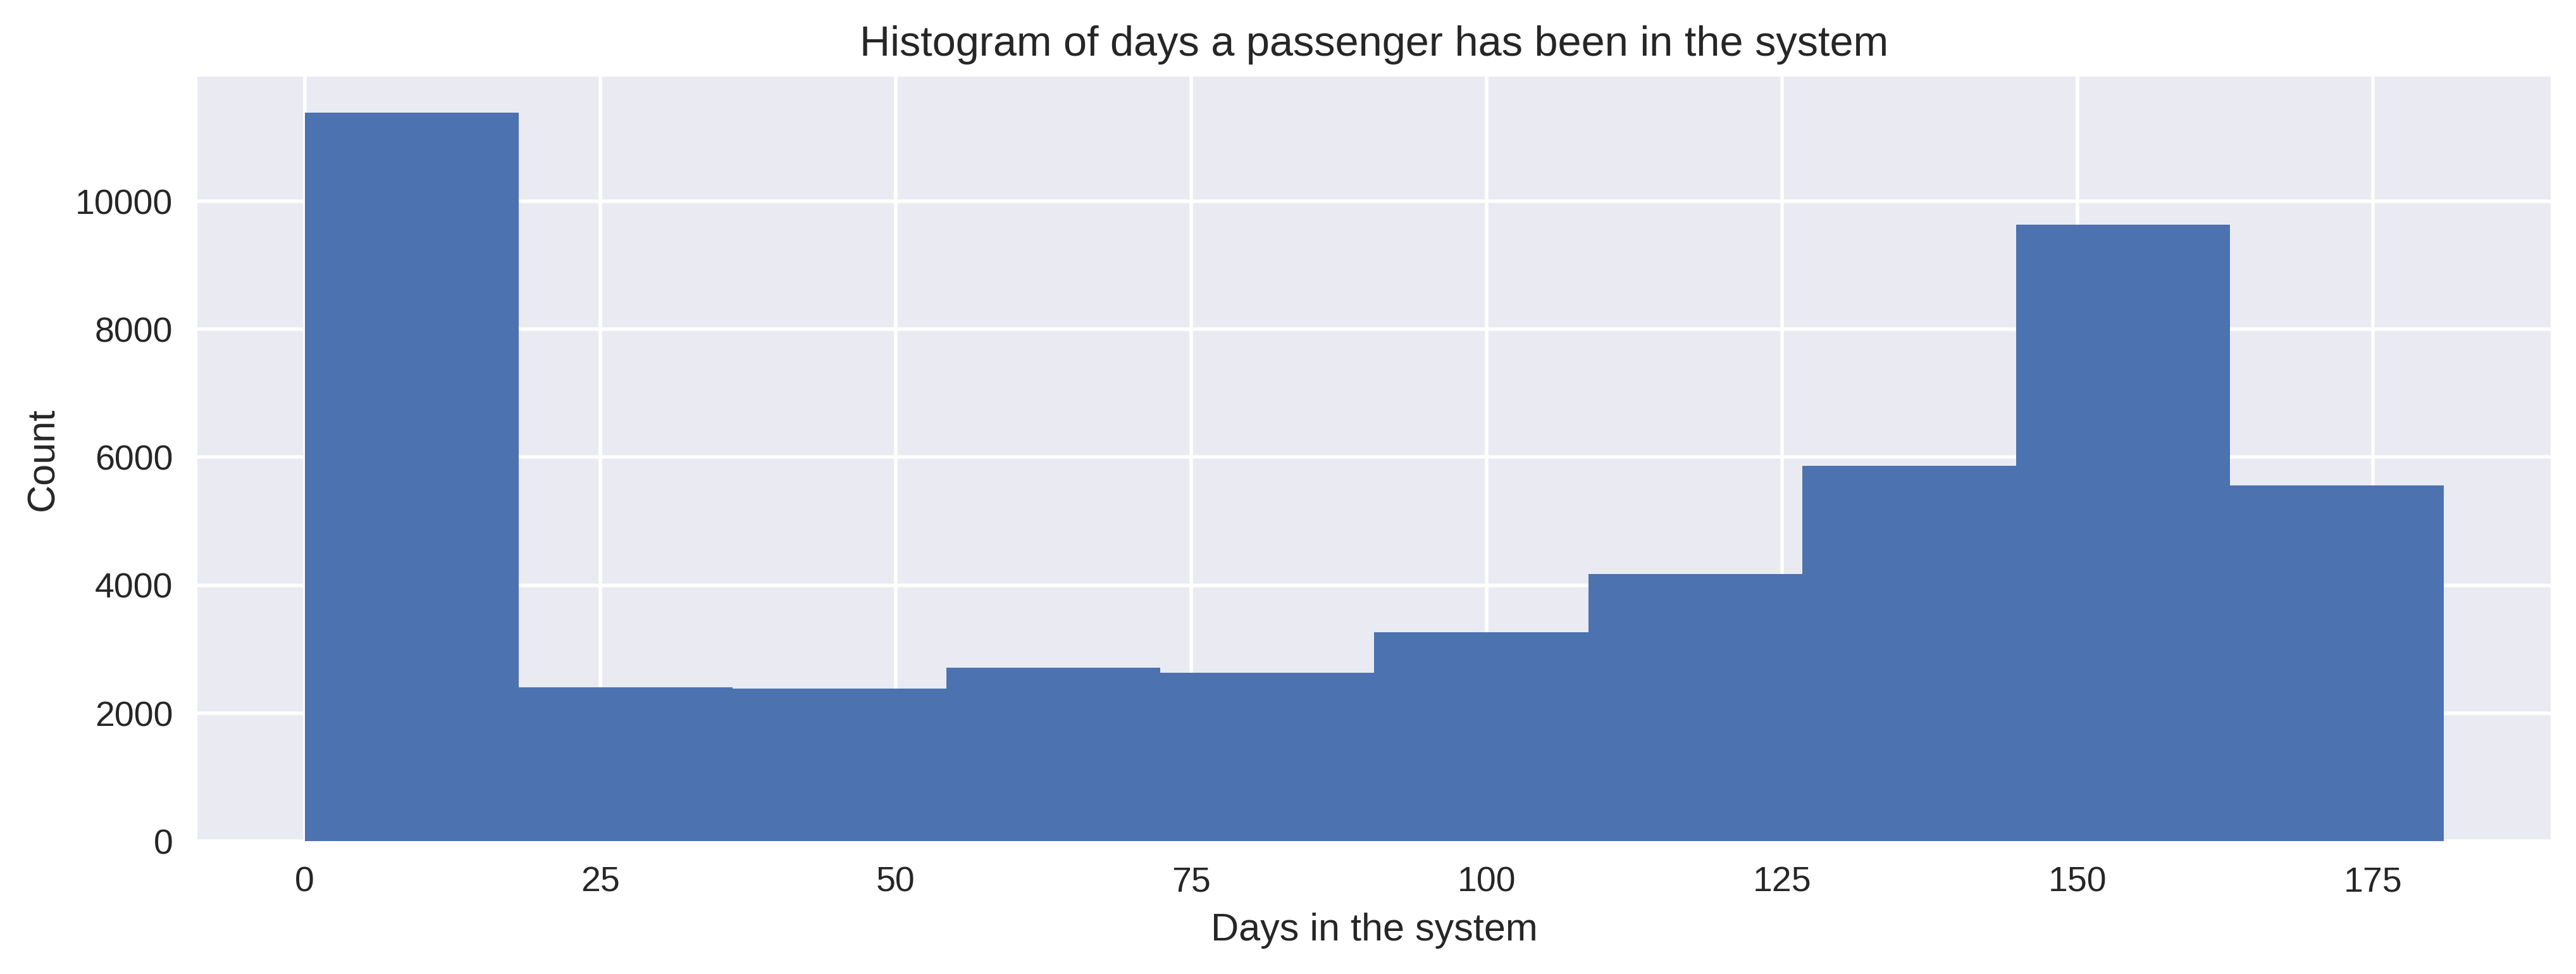

In [63]:
fig = plt.figure(figsize=(12,4), dpi=400)

axes = fig.add_subplot(111, title = "Histogram of days a passenger has been in the system",
                      xlabel = "Days in the system",
                      ylabel = "Count")
    
predictDF.days_in_system.apply(lambda x: x.days).hist(ax=axes);

We need to filter out users that have been less than 5 months in the system and are active on the last month. Otherwise we risk to classify them as retained, when they are not.

Now we set up the target feature ("retained"):

In [67]:
# convert the time period to days
predictDF.loc[:, 'days_n'] = predictDF.days_in_system.apply(lambda x: x.days)

# create target value
predictDF4 = predictDF
latest_trip = (pd.to_datetime(predictDF4.last_trip_date)).max()
predictDF.loc[:, 'retained'] = pd.to_datetime(predictDF4.last_trip_date) > (latest_trip - pd.Timedelta('31 day')) 

# filter out signups later than the January 31, 2014
predictDF4 = predictDF[ ~((pd.to_datetime(predictDF.signup_date) > pd.to_datetime("2014-01-31") ) & 
                       predictDF.retained) ]


We can use the describe method of the dataframe to explore the features' values:

In [69]:
predictDF4.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  \
count  50000.000000            50000.000000  50000.000000   
mean       8.849536                2.278200     60.926084   
std       19.958811                3.792684     37.081503   
min        0.000000                0.000000      0.000000   
25%        0.000000                0.000000     33.300000   
50%        0.000000                1.000000     66.700000   
75%        8.600000                3.000000    100.000000   
max      100.000000              125.000000    100.000000   

                days_in_system        days_n  
count                    50000  50000.000000  
mean   92 days 18:57:44.640000     92.790100  
std    62 days 03:06:56.580842     62.129822  
min            0 days 00:00:00      0.000000  
25%           27 days 00:00:00     27.000000  
50%          110 days 00:00:00    110.000000  
75%          150 days 00:00:00    150.000000  
max          181 days 00:00:00    181.000000

Looking at the count values it is easy to identify those features that are missing values. Having 50,000 rows we can afford dropping some of them. From the above table we will drop average ratings with missing values.

It is required to check other categorical features for missing values:

In [70]:
predictDF.city.value_counts(), predictDF4.city.isnull().value_counts()

(Winterfell        23336
 Astapor           16534
 King's Landing    10130
 Name: city, dtype: int64, False    50000
 Name: city, dtype: int64)

There are no missing values for 'city' feature.

Checking 'phone':

In [71]:
predictDF.phone.value_counts(), predictDF4.phone.isnull().value_counts()

(iPhone     34582
 Android    15022
 Name: phone, dtype: int64, False    49604
 True       396
 Name: phone, dtype: int64)

There is a small number of records which do miss the phone type.

Another way to check the missing values for all predictors:

In [72]:
predictDF.isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
days_in_system            False
days_n                    False
retained                  False
dtype: bool

Ommitting the records where no phone types are present, let's have a look at the average ratings. It's interesting how the average ratings of drivers and by drivers are ranked:

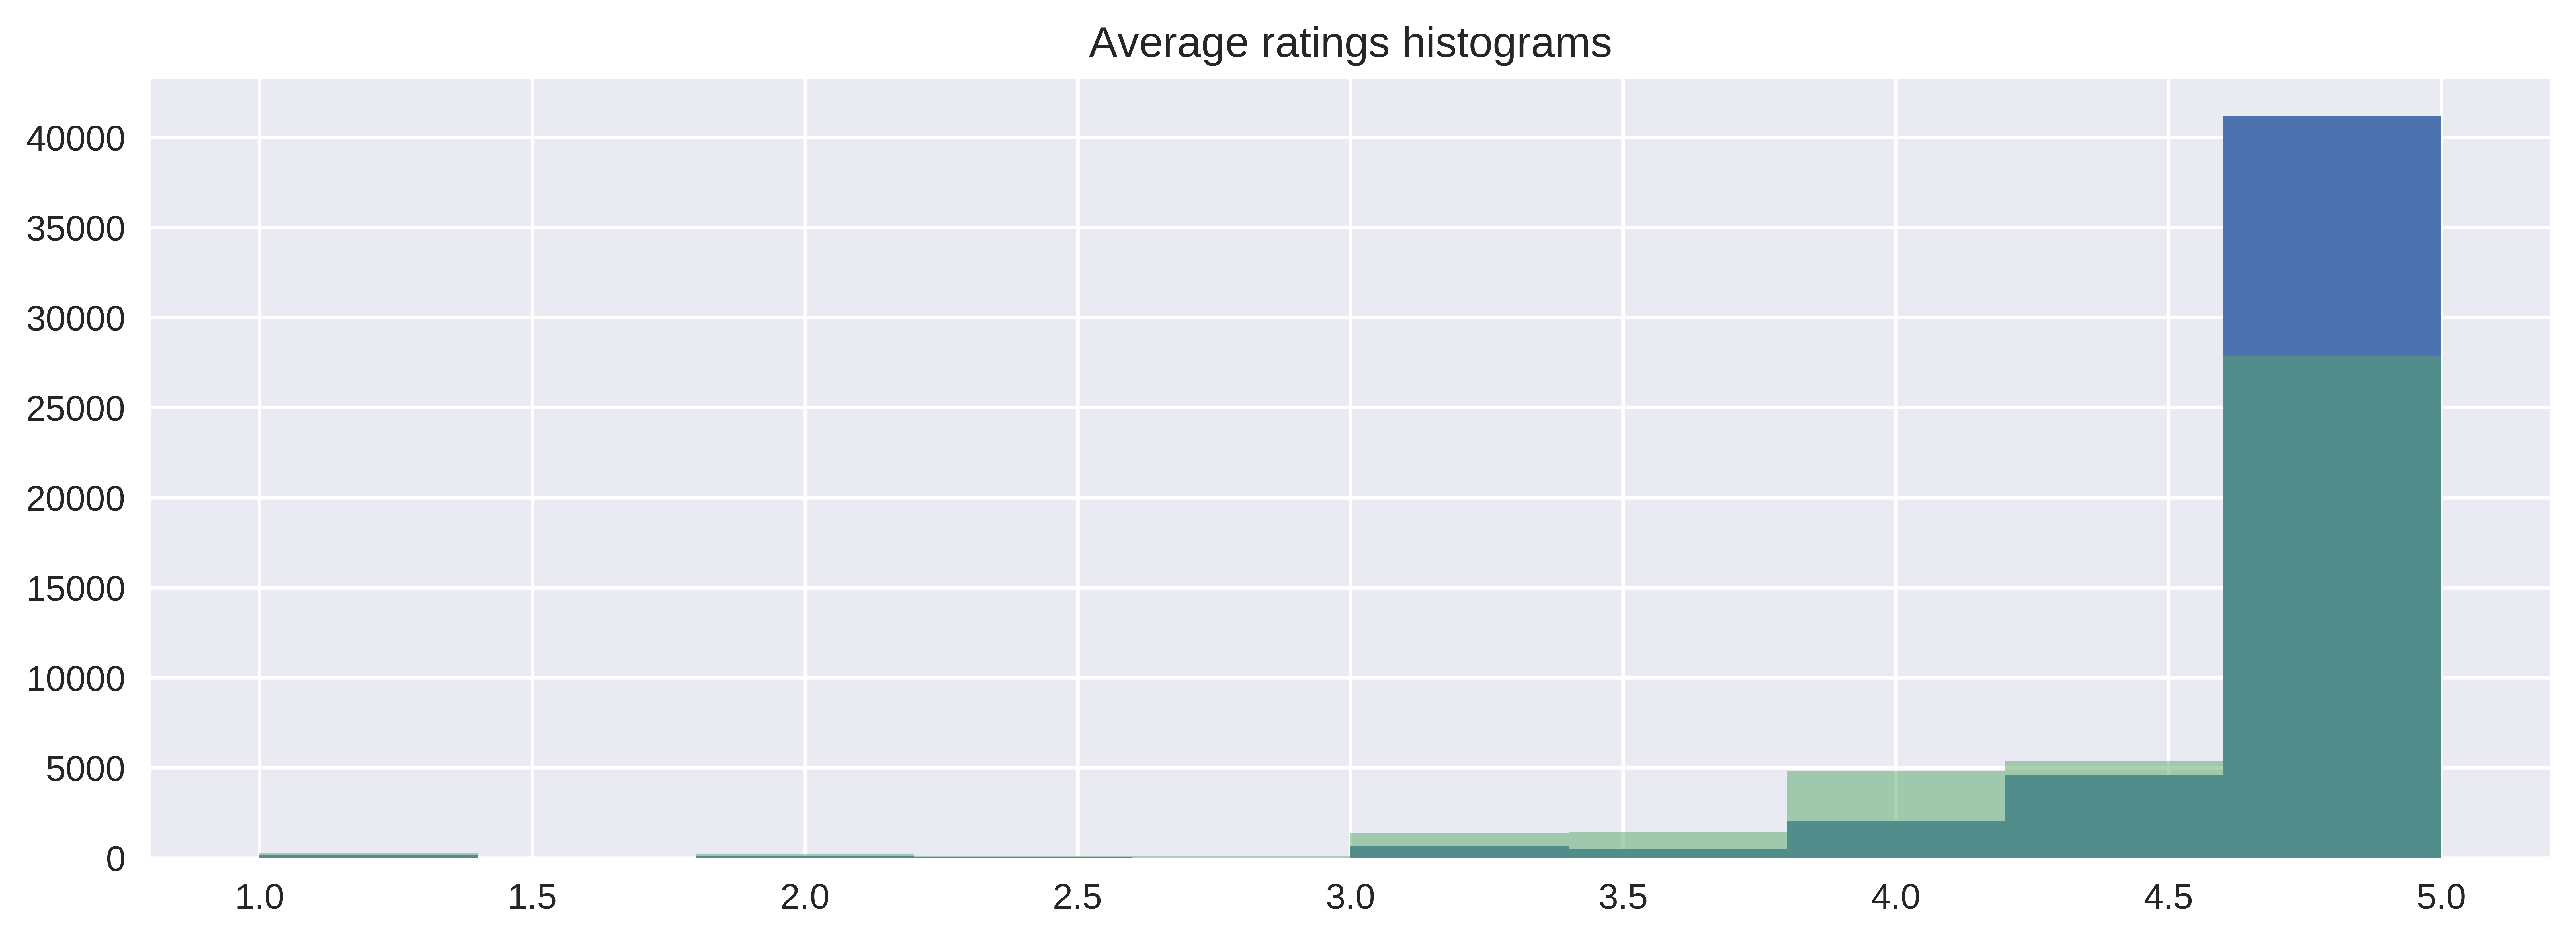

In [74]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = 'Average ratings histograms')
predictDF4[~predictDF4.phone.isnull()].avg_rating_by_driver.hist(ax = axes)
predictDF4[~predictDF4.phone.isnull()].avg_rating_of_driver.hist(alpha=0.5, ax = axes)

The average rating of a driver is displayed in a transparent green color. The histogram shows that drivers get worse reviews in general. But they rate higher the passengers.

### Correlation between average ratings

In [51]:
from scipy import stats

In [168]:
stats.pearsonr(predictDF4[(~predictDF4.phone.isnull()) & 
                         (~predictDF4.avg_rating_by_driver.isnull()) & 
                         (~predictDF4.avg_rating_of_driver.isnull()) ].avg_rating_by_driver, 
               predictDF4[(~predictDF4.phone.isnull()) & 
                         (~predictDF4.avg_rating_by_driver.isnull()) & 
                         (~predictDF4.avg_rating_of_driver.isnull()) ].avg_rating_of_driver)

(0.12241319491819809, 4.2724756875543342e-138)

The average ratings are not correlated. There is no indication that a good rating from a driver will yield a good rating from the customer or vice versa.

In [85]:
predictDF.groupby(['retained']).describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
retained                                                                   
False    count  31196.000000          31031.000000          24706.000000   
         mean       6.207939              4.787464              4.607557   
         std        6.238675              0.504648              0.664418   
         min        0.000000              1.000000              1.000000   
         25%        2.320000              4.800000              4.400000   
         50%        4.030000              5.000000              5.000000   
         75%        7.800000              5.000000              5.000000   
         max      129.890000              5.000000              5.000000   
True     count  18804.000000          18768.000000          17172.000000   
         mean       5.114788              4.762772              4.592930   
         std        4.615175              0.328489              0.542386   
         min        0.000000              1.000000              1.000000   
         25%        2.560000              4.700000              4.300000   
         50%        3.730000              4.800000              4.800000   
         75%        5.890000              5.000000              5.000000   
         max      160.960000              5.000000              5.000000   

                   avg_surge     surge_pct  trips_in_first_30_days  \
retained                                                             
False    count  31196.000000  31196.000000            31196.000000   
         mean       1.075339      8.666739                1.658482   
         std        0.251361     22.179139                2.654222   
         min        1.000000      0.000000                0.000000   
         25%        1.000000      0.000000                0.000000   
         50%        1.000000      0.000000                1.000000   
         75%        1.000000      0.000000                2.000000   
         max        8.000000    100.000000               73.000000   
True     count  18804.000000  18804.000000            18804.000000   
         mean       1.073809      9.152797                3.306318   
         std        0.163170     15.588704                4.986743   
         min        1.000000      0.000000                0.000000   
         25%        1.000000      0.000000                0.000000   
         50%        1.000000      0.000000                2.000000   
         75%        1.090000     13.300000                4.000000   
         max        4.500000    100.000000              125.000000   

                 weekday_pct  
retained                      
False    count  31196.000000  
         mean      60.647032  
         std       40.982688  
         min        0.000000  
         25%       16.700000  
         50%       69.600000  
         75%      100.000000  
         max      100.000000  
True     count  18804.000000  
         mean      61.389034  
         std       29.487584  
         min        0.000000  
         25%       44.400000  
         50%       64.300000  
         75%       84.600000  
         max      100.000000

The table above is hard to read and try to explore some of the variables that might affect whether passengers are going to continue using the service.

We can explore the data with visualizations. We can plot how surge multiplier affects passengers in each of the cities:

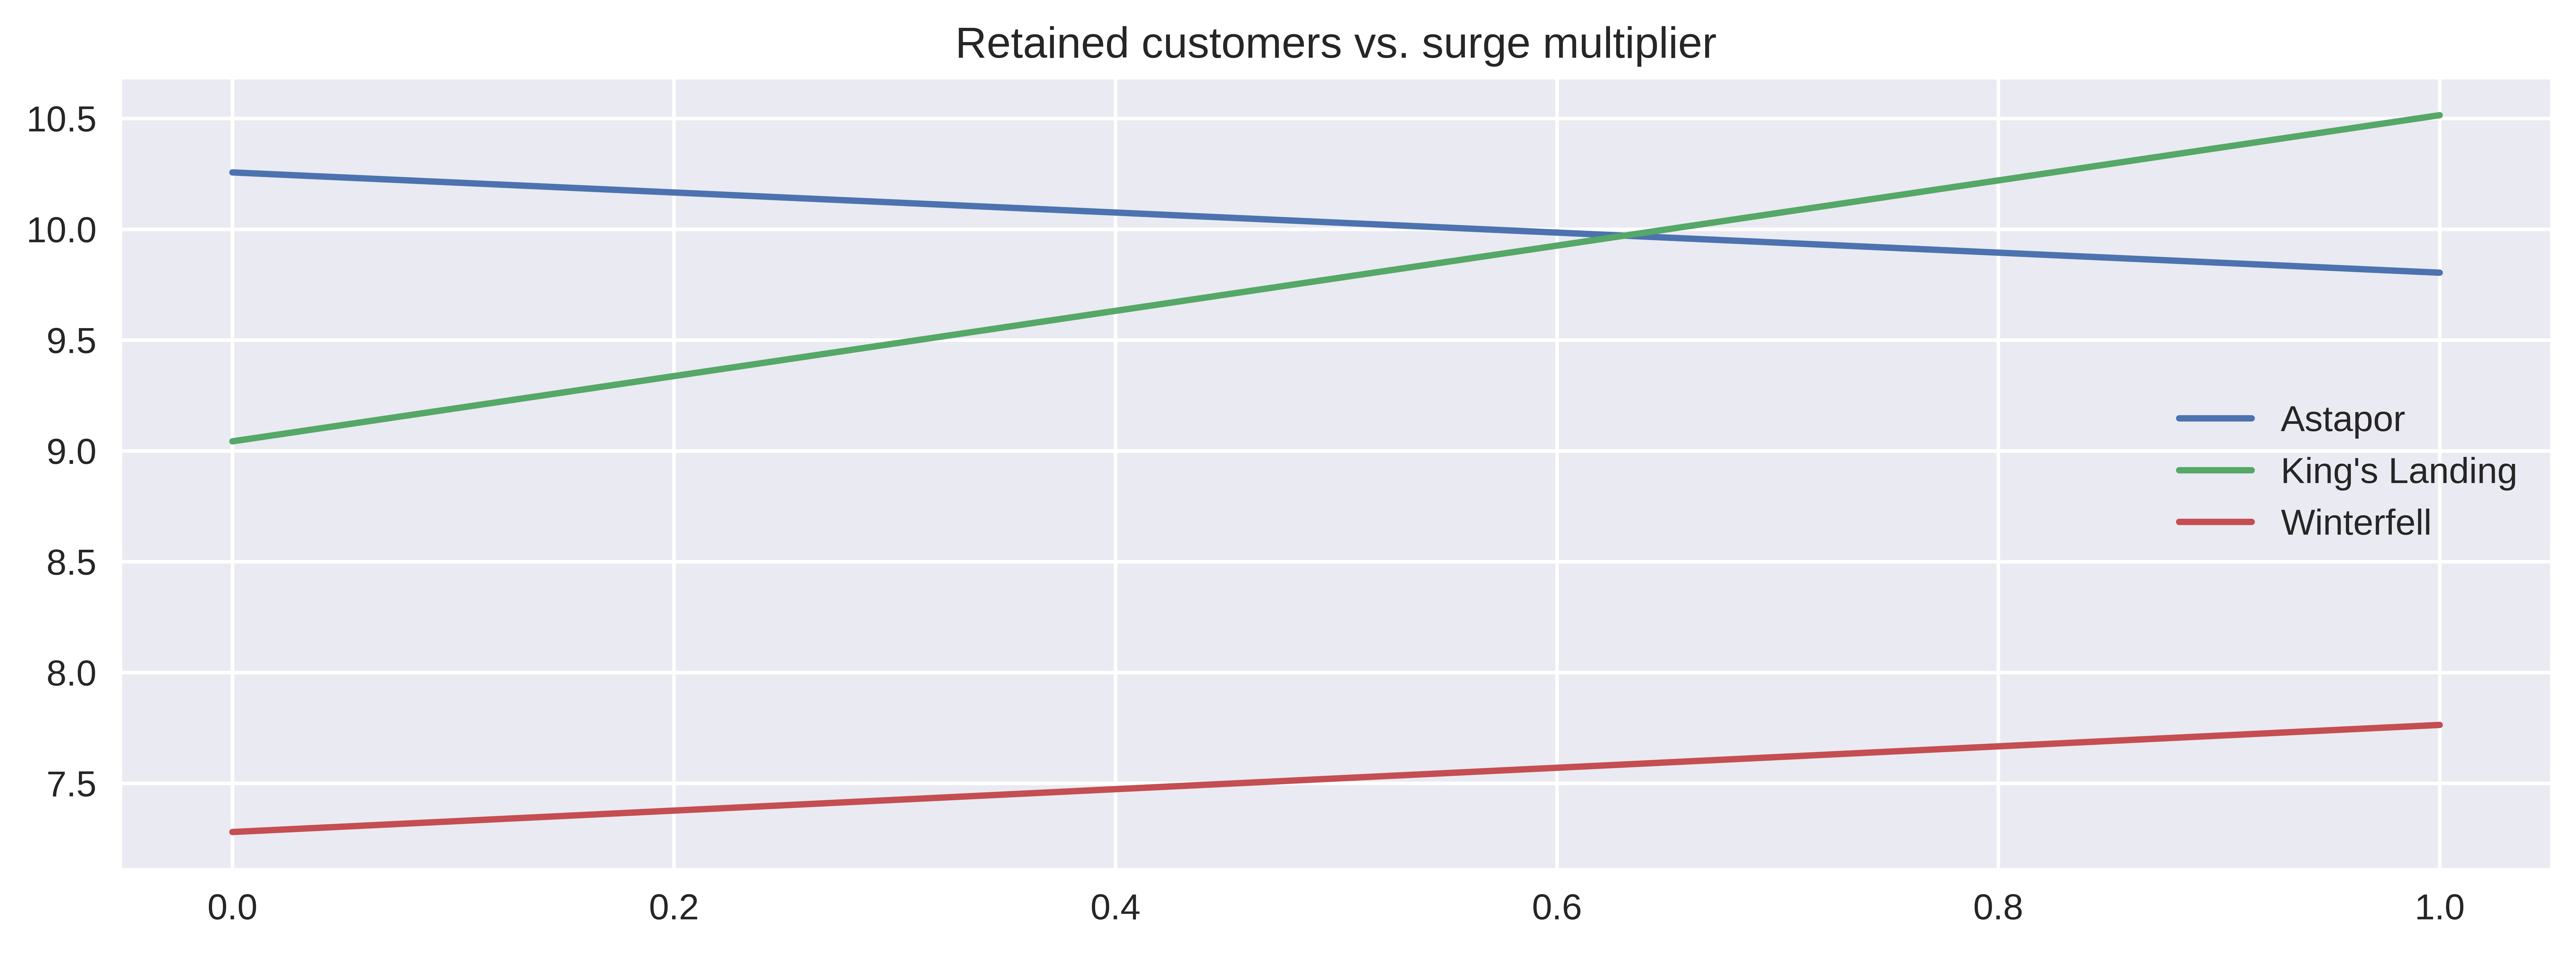

In [83]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. surge multiplier",
                      xlabel = "Retained (1) - churn (0)",
                      ylabel = "Surge percent")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='surge_pct', margins=False), axes = axes);
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='surge_pct', margins=False).columns);

The above plot holds some interesting facts. The Astapor has the highest surge multiplier for churned class. The retained passengers for this city have a lower surge multiplier. In Astapor the churn might have caused by the highest surge multipliers. In other cities the retained passengers have a higher average surge percent then the passenger that churned. The surge price in Winterfell and King's Landing does not seem to cause issues.

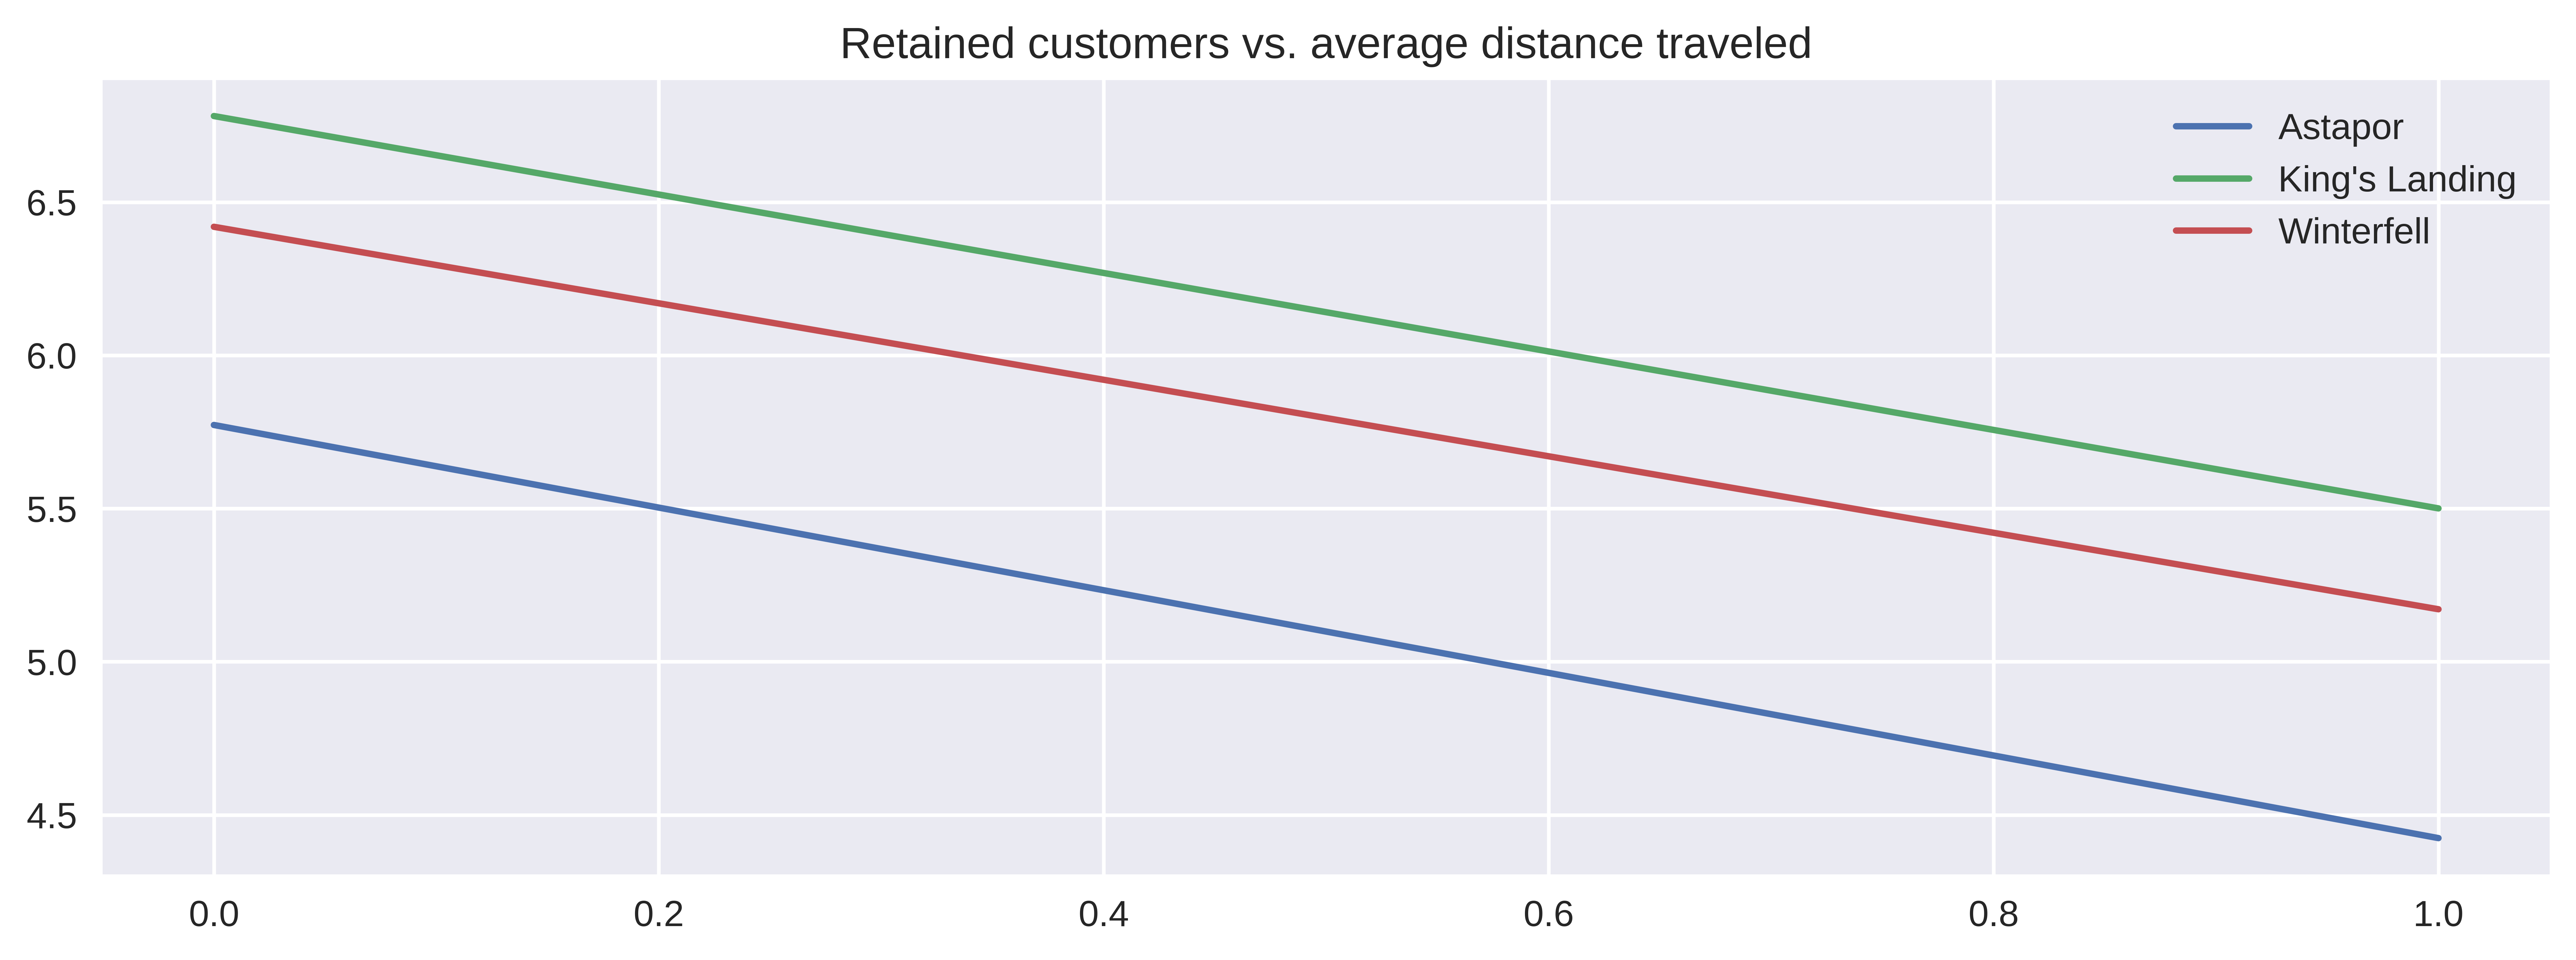

In [86]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. average distance traveled", 
                       xlabel = "Retained (1) - churn (0)",
                      ylabel = "Average distance")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='avg_dist', margins=False), axes=axes)
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='avg_dist', margins=False).columns)

In the above plot it is interesting to note that the passengers that continued to use the service have indeed traveled less than the passengers that decided to abandon the service in their first 30 days.  

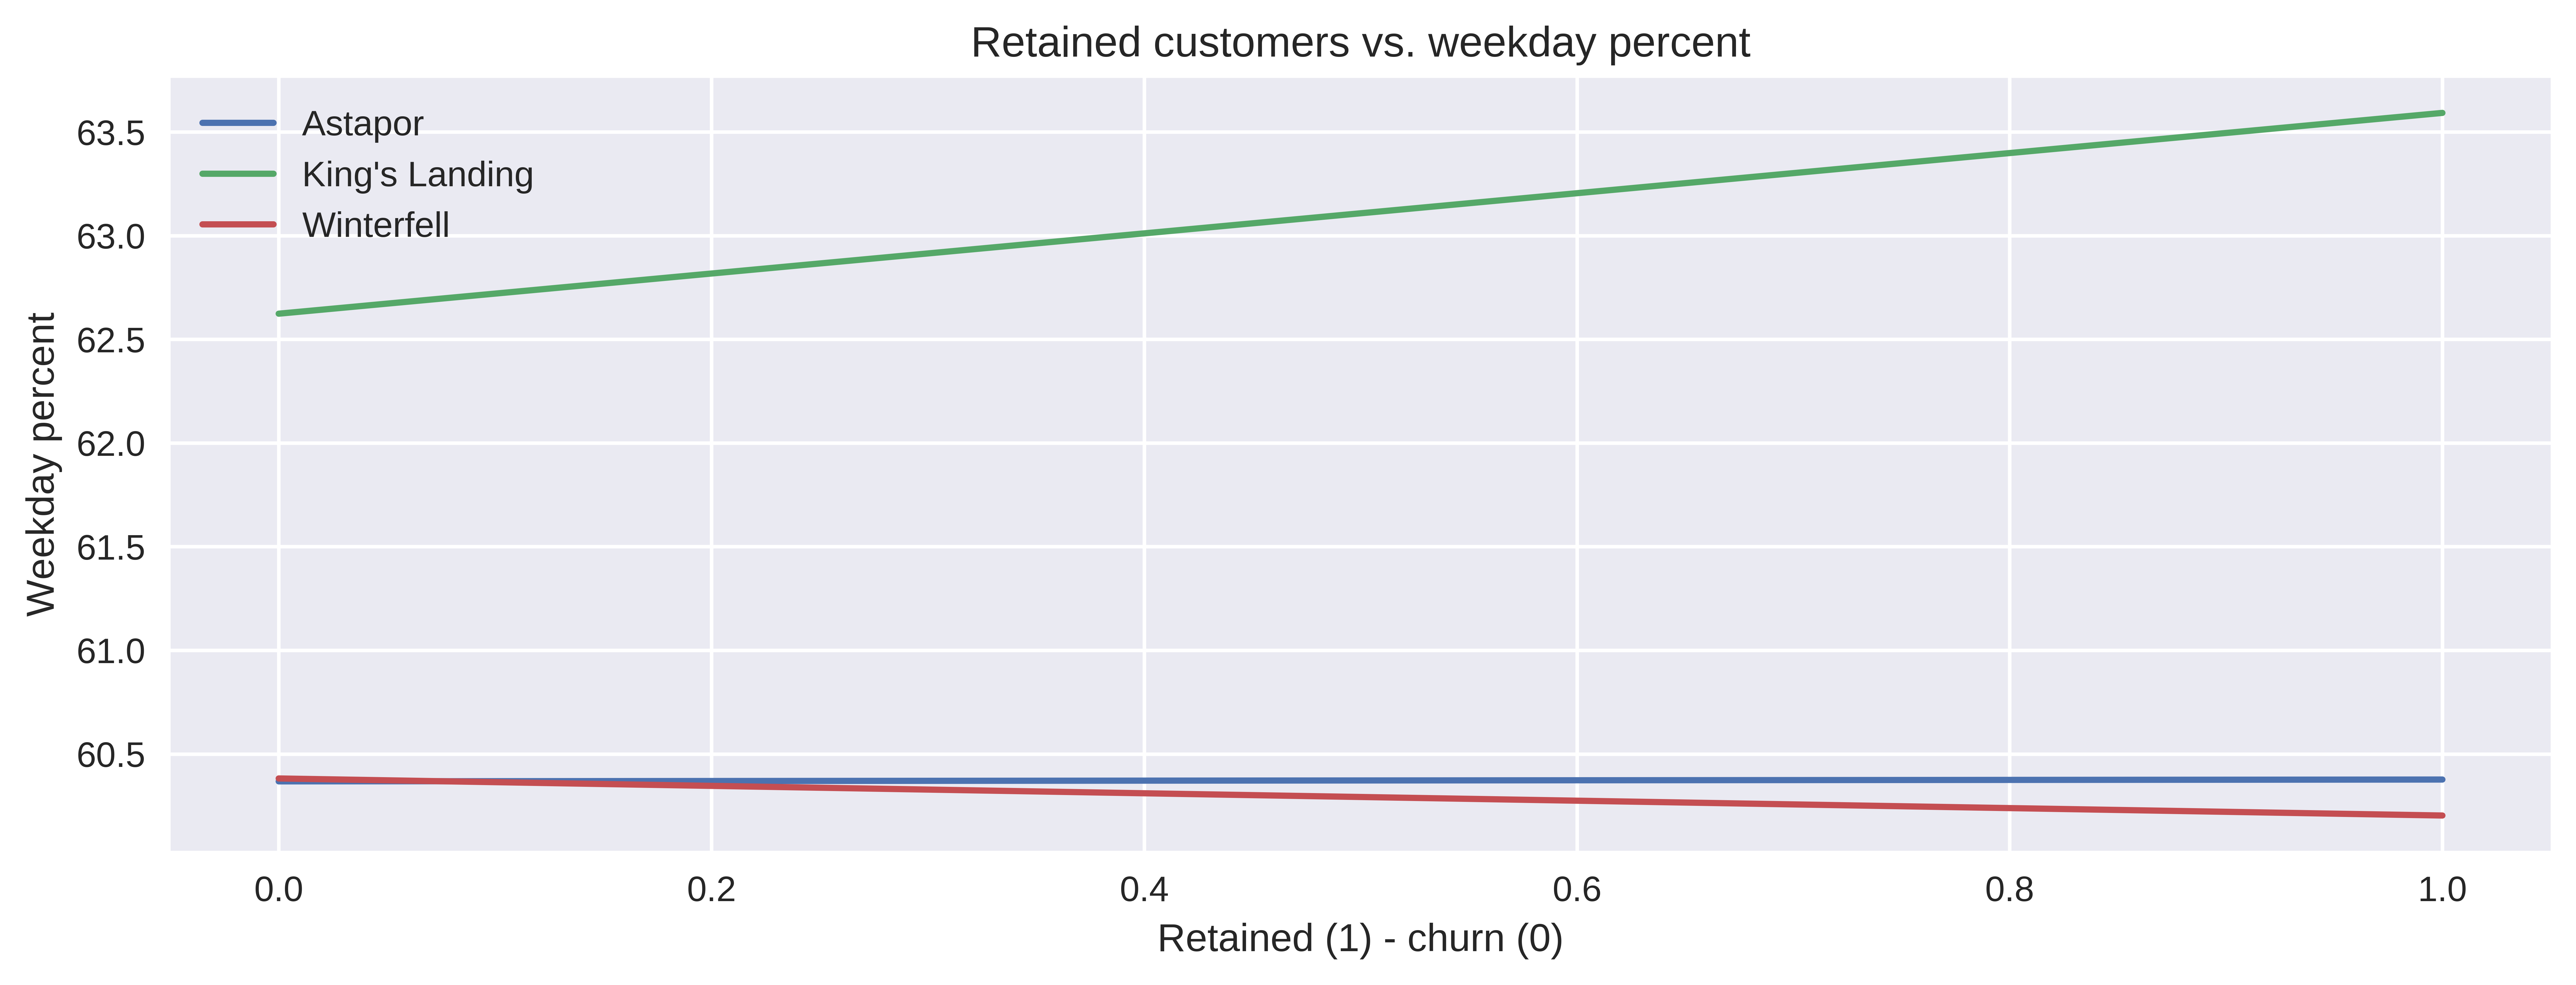

In [89]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. weekday percent",
                      xlabel = "Retained (1) - churn (0)",
                      ylabel = "Weekday percent")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='weekday_pct'), axes=axes)
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='weekday_pct').columns)

In King's Landing the retained passengers use the service more than any other passengers in other cities and also then the ones that decided to abandon. While in other cities the contrary is observed. 

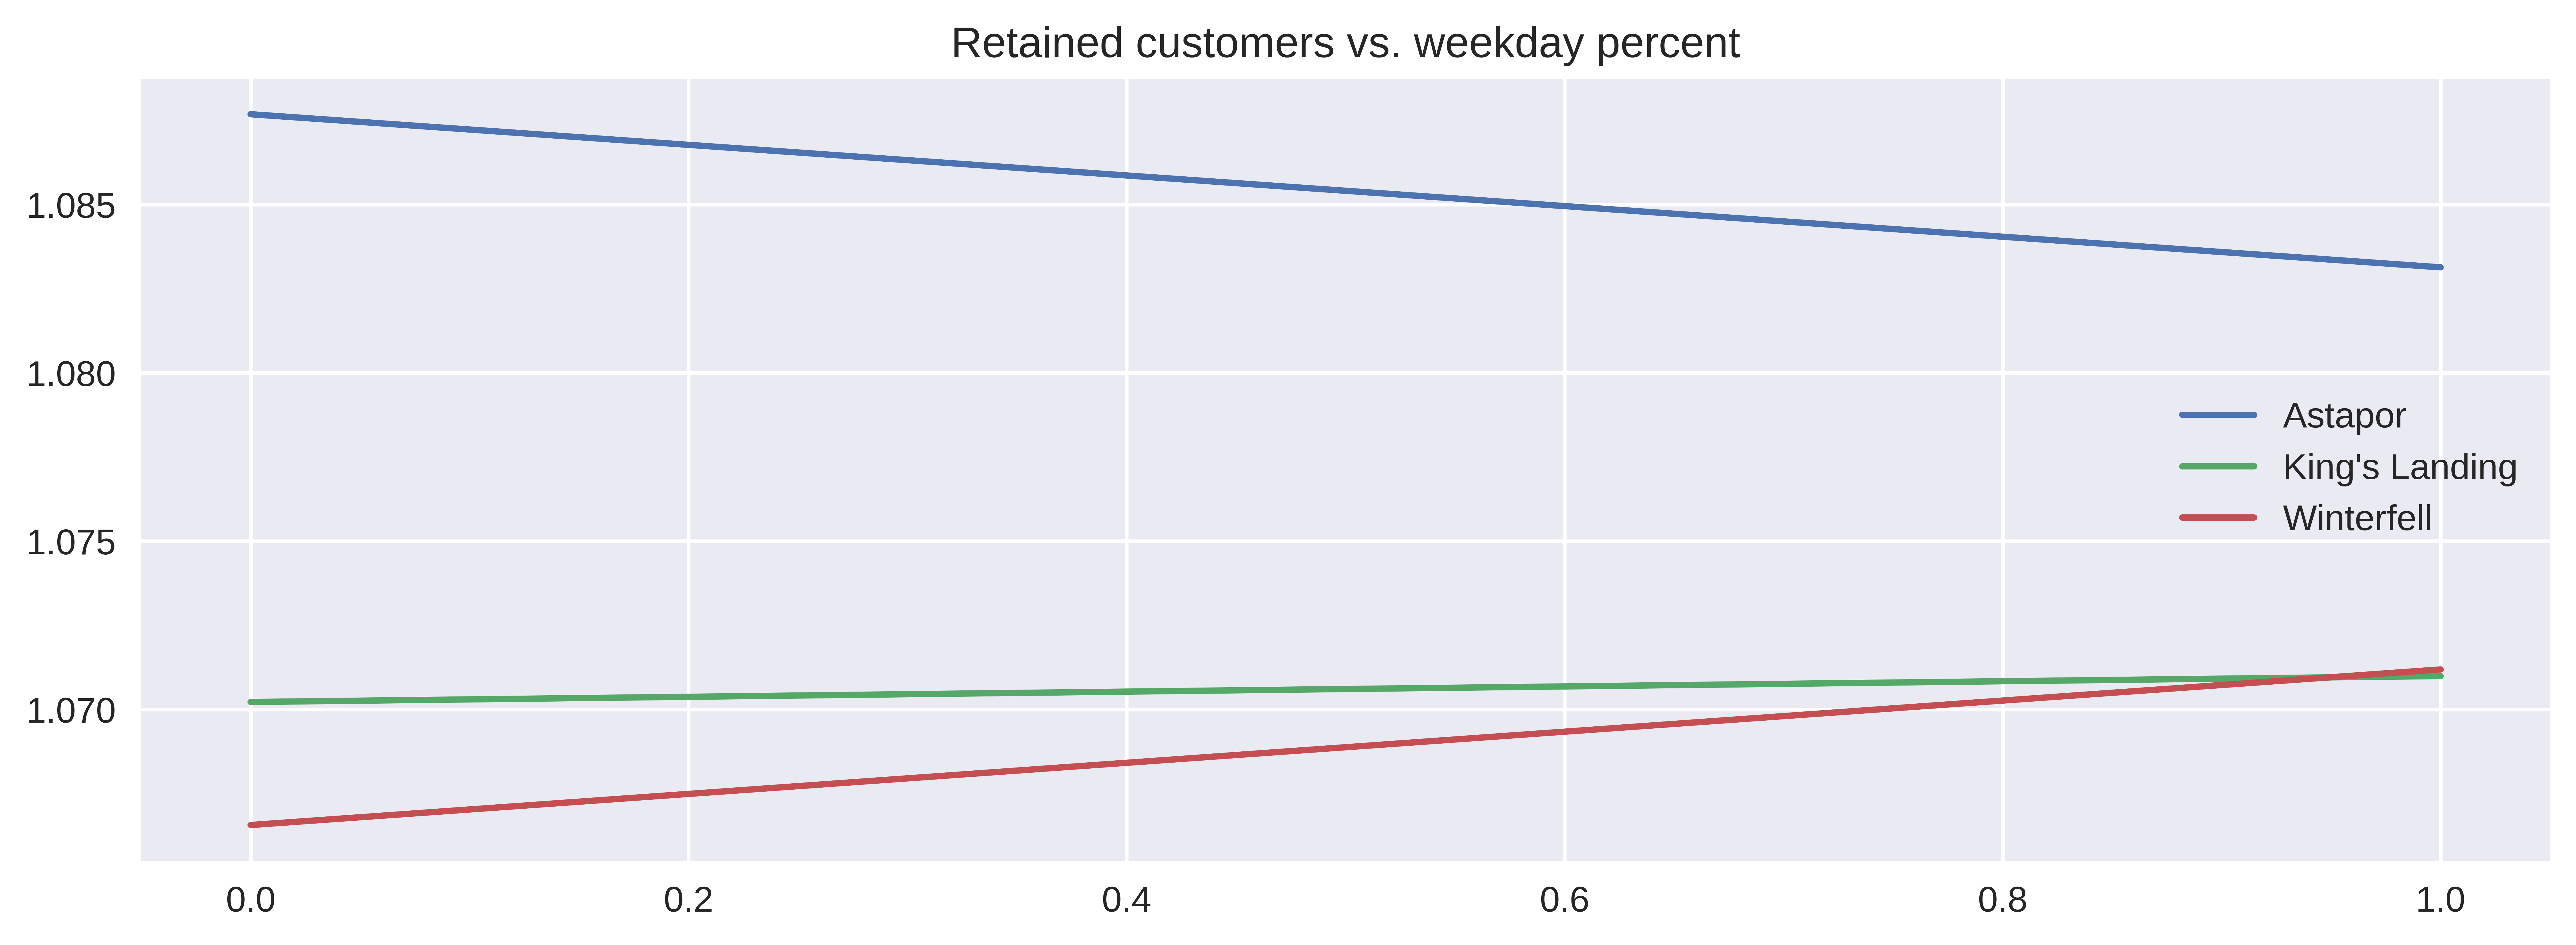

In [88]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. average surge",
                      xlabel = "Retained (1) - churn (0)",
                      ylabel = "Average Surge")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='avg_surge'), axes=axes);
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='avg_surge').columns)

The above plot correlates with the one above. Astapor city has the highest level of surge and the passengers leaving the service seem to suffer from it.

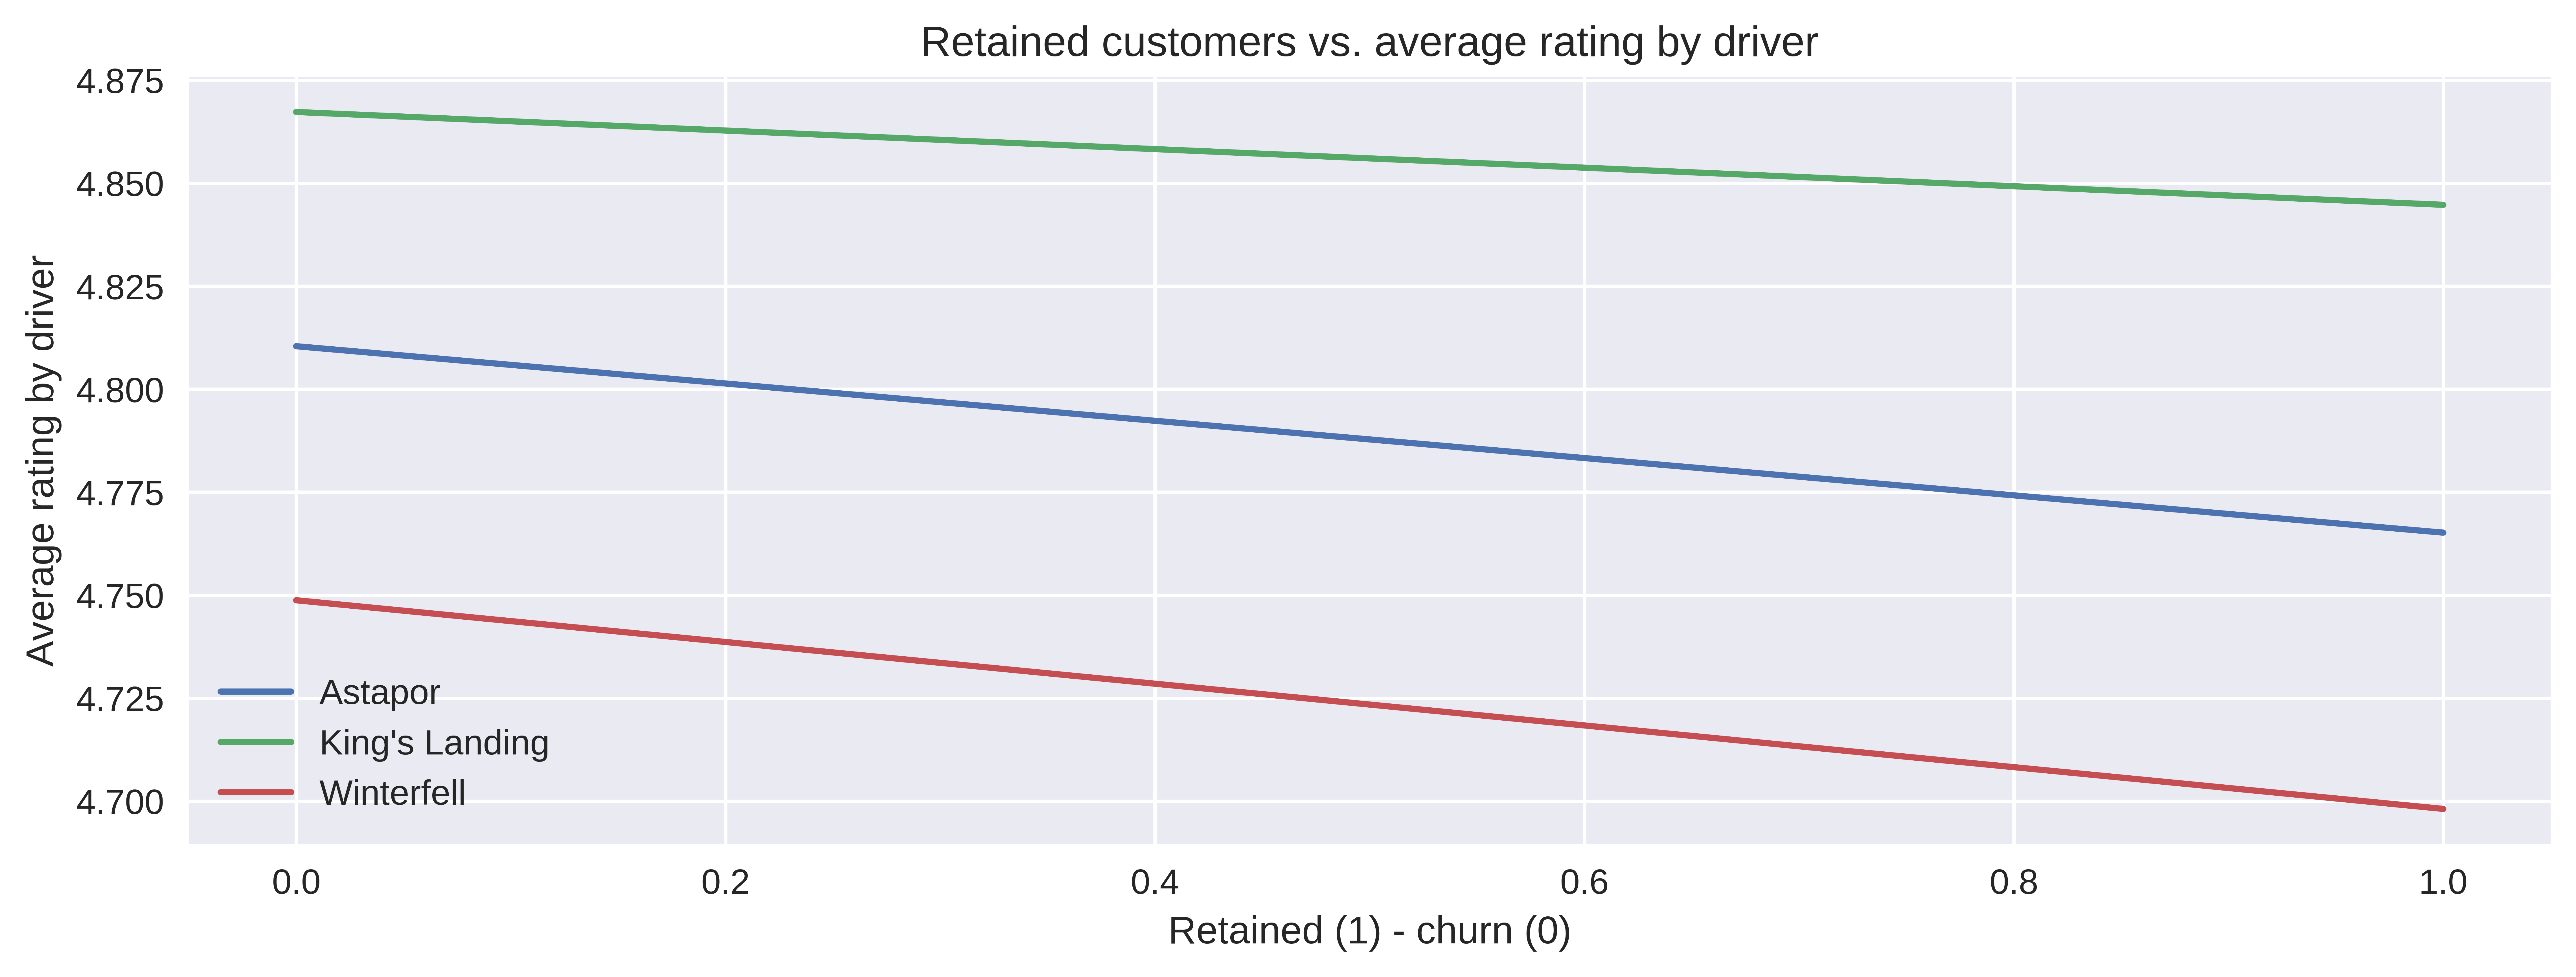

In [92]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. average rating by driver",
                      xlabel = "Retained (1) - churn (0)",
                      ylabel = "Average rating by driver")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='avg_rating_by_driver'), axes = axes);
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='avg_rating_by_driver').columns);

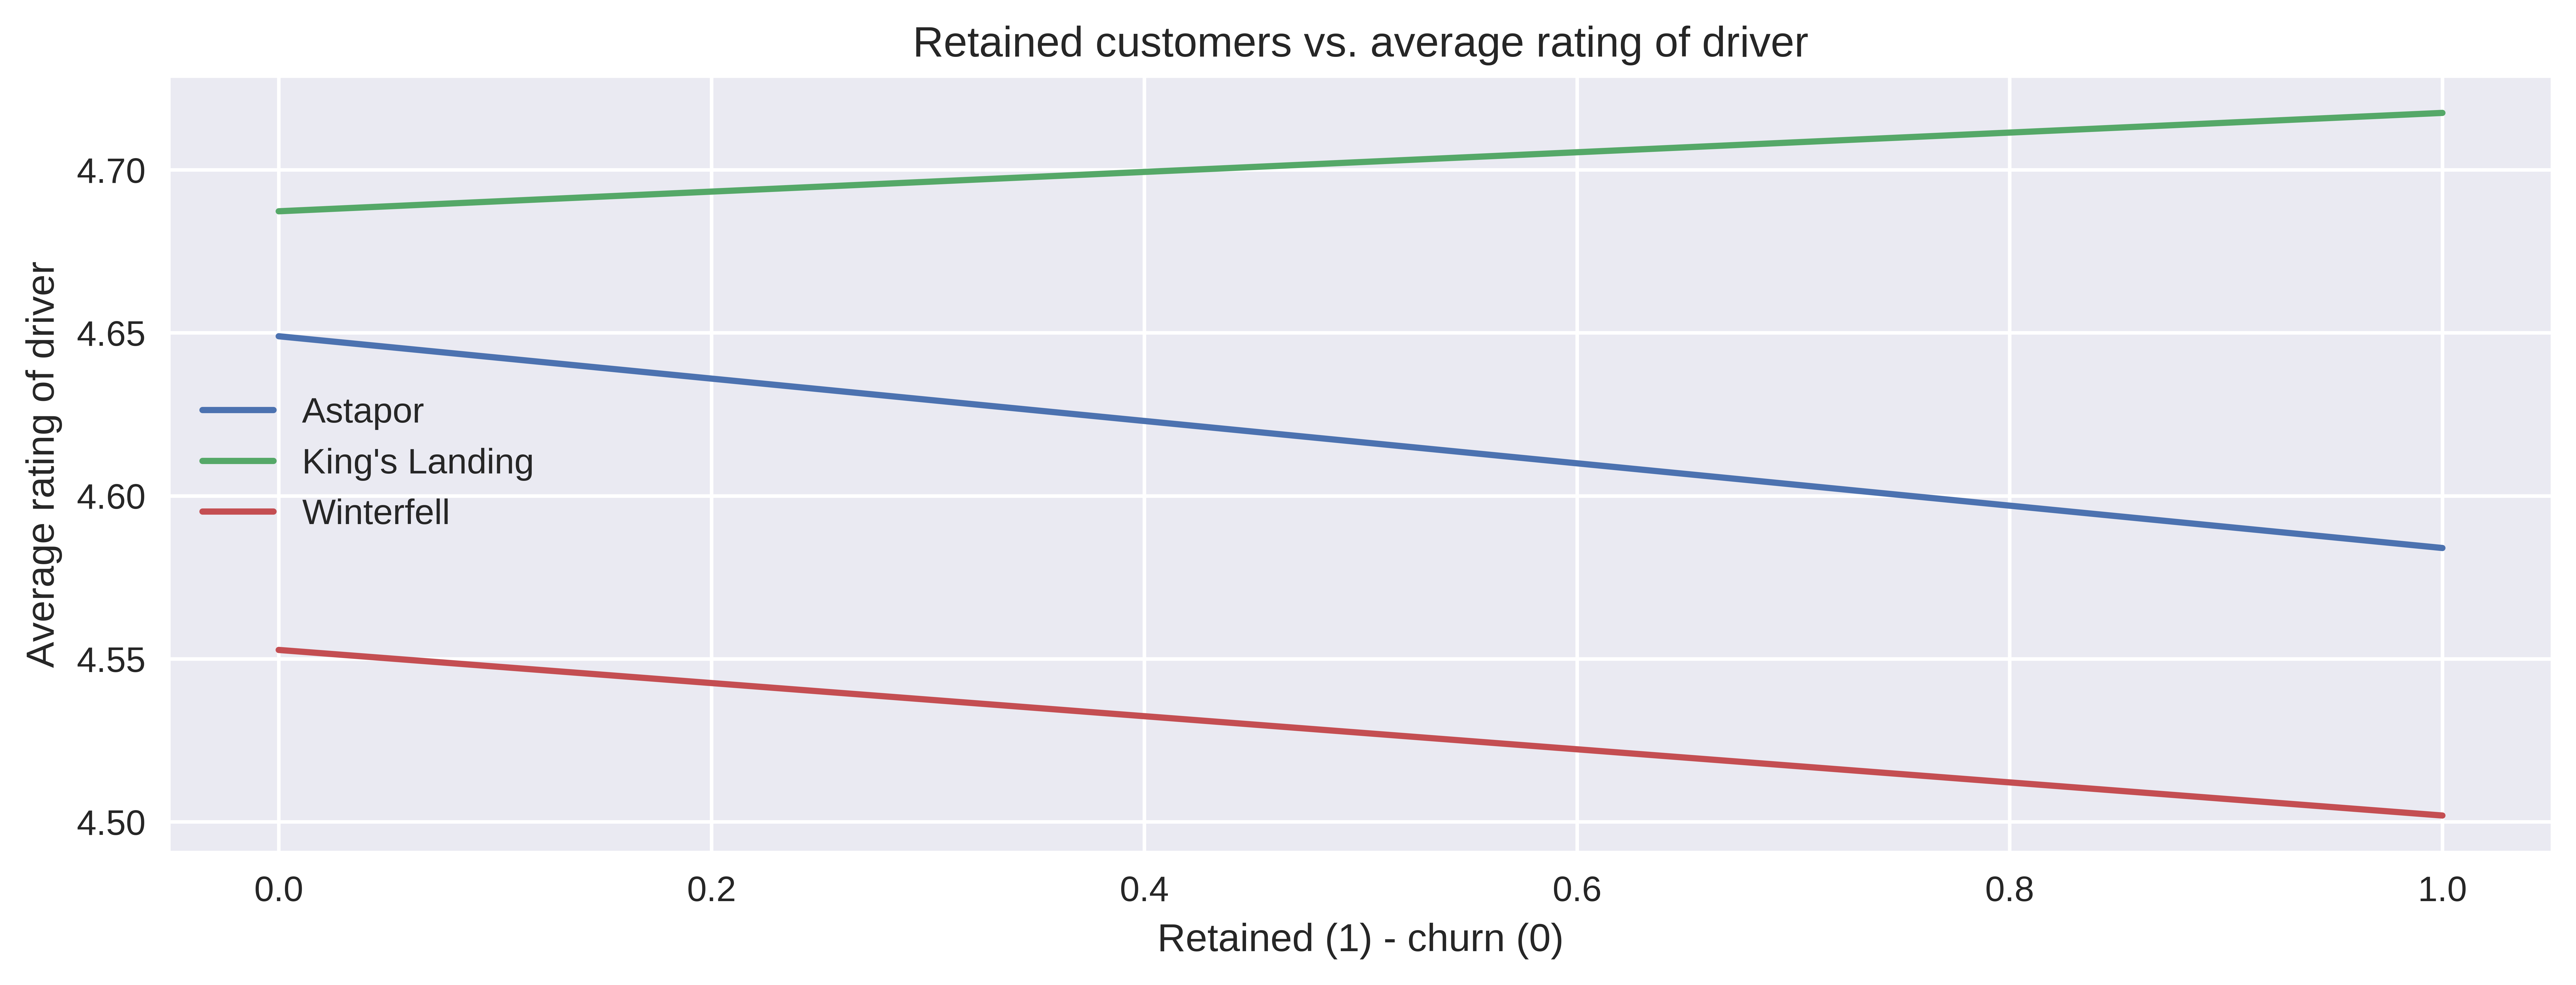

In [93]:
fig  = plt.figure(figsize=(12,4), dpi=900)

axes = fig.add_subplot(111, title = "Retained customers vs. average rating of driver",
                      xlabel = "Retained (1) - churn (0)",
                      ylabel = "Average rating of driver")

plt.plot(predictDF.pivot_table(index='retained', columns='city', values='avg_rating_of_driver'), axes = axes)
plt.legend(predictDF.pivot_table(index='retained', columns='city', values='avg_rating_of_driver').columns)

In King's Landing city the passengers that have been retained have actually rated the drivers better than in other cities. While in other cities the passengers that have continued using the service have rated the drivers worse than those that left.

We can check in general how many passengers are retained in each of the cities. We use the crosstab:

In [259]:
pd.crosstab( predictDF4.city, predictDF4.retained, margins=True, normalize=True )

retained           False      True       All
city                                        
Astapor         0.233563  0.092388  0.325950
King's Landing  0.073326  0.138400  0.211726
Winterfell      0.282085  0.180239  0.462324
All             0.588973  0.411027  1.000000

In the above table we see that King's Landing city is more inclined to stay with the service. The percent of the customers retained is lower in other cities. 

We can use Chi-square test on contigency table to check whether the distribution of the passengers being retained is independent on the city where they live:

In [256]:
from scipy.stats import chi2_contingency

chi2_contingency(pd.crosstab( predictDF4.city, predictDF4.retained ).values )  #groupby(['phone', 'retained']).count()

(3078.0607323813329, 0.0, 2, array([[  7956.44082519,   5552.55917481],
        [  5168.24104235,   3606.75895765],
        [ 11285.31813246,   7875.68186754]]))

The above result allows us to reject the hypothesis that the percentage of the customers retained is indipendent from the city where they reside.

In the table below we are able to see that the churn is also related to the type of the phone a passenger uses:

In [280]:
pd.crosstab(predictDF4.phone, predictDF4.retained, margins=True)

retained  False   True    All
phone                        
Android    9289   2804  12093
iPhone    15121  14231  29352
All       24410  17035  41445

Android users have a higher rate of decline. 

In the table below we try to explore the success retaining a passenger by transforming weekday percent travels to 3 classes:
    - 0 %
    - between 0-100% excluding the interval extreme values
    - the 100% class

In [263]:
pd.crosstab(predictDF4.weekday_pct.apply(lambda x: 0 if x == 0 else (2 if x == 100 else 1)),
            predictDF4.retained)

retained     False  True 
weekday_pct              
0             5114   1058
1             9821  13374
2             9475   2603

The ones that are using the service moderately on weekdays have a higher rate of retainment than those who does not travel at all on weekdays or those who travel 100%.

Another factor is the percent of trips with surge multiplier > 1:

In [306]:
pd.crosstab(predictDF4.surge_pct.apply(lambda x: x // 10 * 10), predictDF4.retained, margins=True)

retained   False   True    All
surge_pct                     
0.0        19217  11214  30431
10.0        1170   2932   4102
20.0        1191   1589   2780
30.0         826    628   1454
40.0         178    172    350
50.0         955    309   1264
60.0         138     67    205
70.0          25     12     37
80.0           9      6     15
100.0        701    106    807
All        24410  17035  41445

From the table above we can conclude that the passengers can tolerate up to 20% of trips with a surge multiplier bigger than 1. If the percent of trips with surge > 1 becomes larger than 20% then the rate of the customer churning goes up.

Let's see how average rating by driver affects the retained passengers:

In [304]:
pd.crosstab(predictDF4.avg_rating_by_driver.apply(np.round), predictDF4.retained, margins=True, normalize=True)

retained                 False      True       All
avg_rating_by_driver                              
1.0                   0.002075  0.000193  0.002268
2.0                   0.002340  0.000169  0.002509
3.0                   0.009024  0.001761  0.010785
4.0                   0.087079  0.066980  0.154060
5.0                   0.488455  0.341923  0.830378
All                   0.588973  0.411027  1.000000

From the above tabular representation it's not easy to draw conclusions, mainly because of the proportions between retained and churned classes. From this dataset we see there is a 2:1 ratio that a passenger will abandon the service. We have to level this ratio to 1:1 in order to draw some fair conclusions. Ideally we would shuffle the records of churned class before undersampling. In this case we would assume that the records are retrieved as a result of a random process. The procedure is the following:

In [309]:
retainedDF = predictDF4[predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']]
nretainedDF = predictDF4[~predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']].head(len(retainedDF))
combinedDF = retainedDF.append(nretainedDF)

In [316]:
pd.crosstab(combinedDF.avg_rating_by_driver.apply(np.round), combinedDF.retained, margins=True, normalize=True)

retained                 False      True       All
avg_rating_by_driver                              
1.0                   0.001644  0.000235  0.001878
2.0                   0.002172  0.000205  0.002377
3.0                   0.008072  0.002143  0.010214
4.0                   0.072234  0.081479  0.153713
5.0                   0.415879  0.415938  0.831817
All                   0.500000  0.500000  1.000000

Now, that the number of records representing each class is equal we can see that there is a higher chance that a higher rating by a driver would predict a retained passenger.

We do revisit the weekday percentage of trips for the combined dataset:

In [318]:
pd.crosstab(combinedDF.weekday_pct.apply(lambda x: x // 10 * 10), combinedDF.retained, margins=True, normalize=True)

retained        False      True       All
weekday_pct                              
0.0          0.105225  0.032052  0.137276
10.0         0.004256  0.008717  0.012973
20.0         0.014764  0.022806  0.037570
30.0         0.022835  0.033490  0.056325
40.0         0.013590  0.039448  0.053038
50.0         0.057617  0.081068  0.138685
60.0         0.039712  0.080305  0.120018
70.0         0.024362  0.060669  0.085031
80.0         0.019724  0.048283  0.068007
90.0         0.003786  0.016760  0.020546
100.0        0.194130  0.076402  0.270531
All          0.500000  0.500000  1.000000

The above detailed cross tabulated dataframe confirms once again that 0 and 100% trips on weekdays do confirm that a passenger is most likely to abandon the service.

For the next analysis we would need to get rid of all missing values:

In [94]:
predictDF4 = predictDF.dropna()

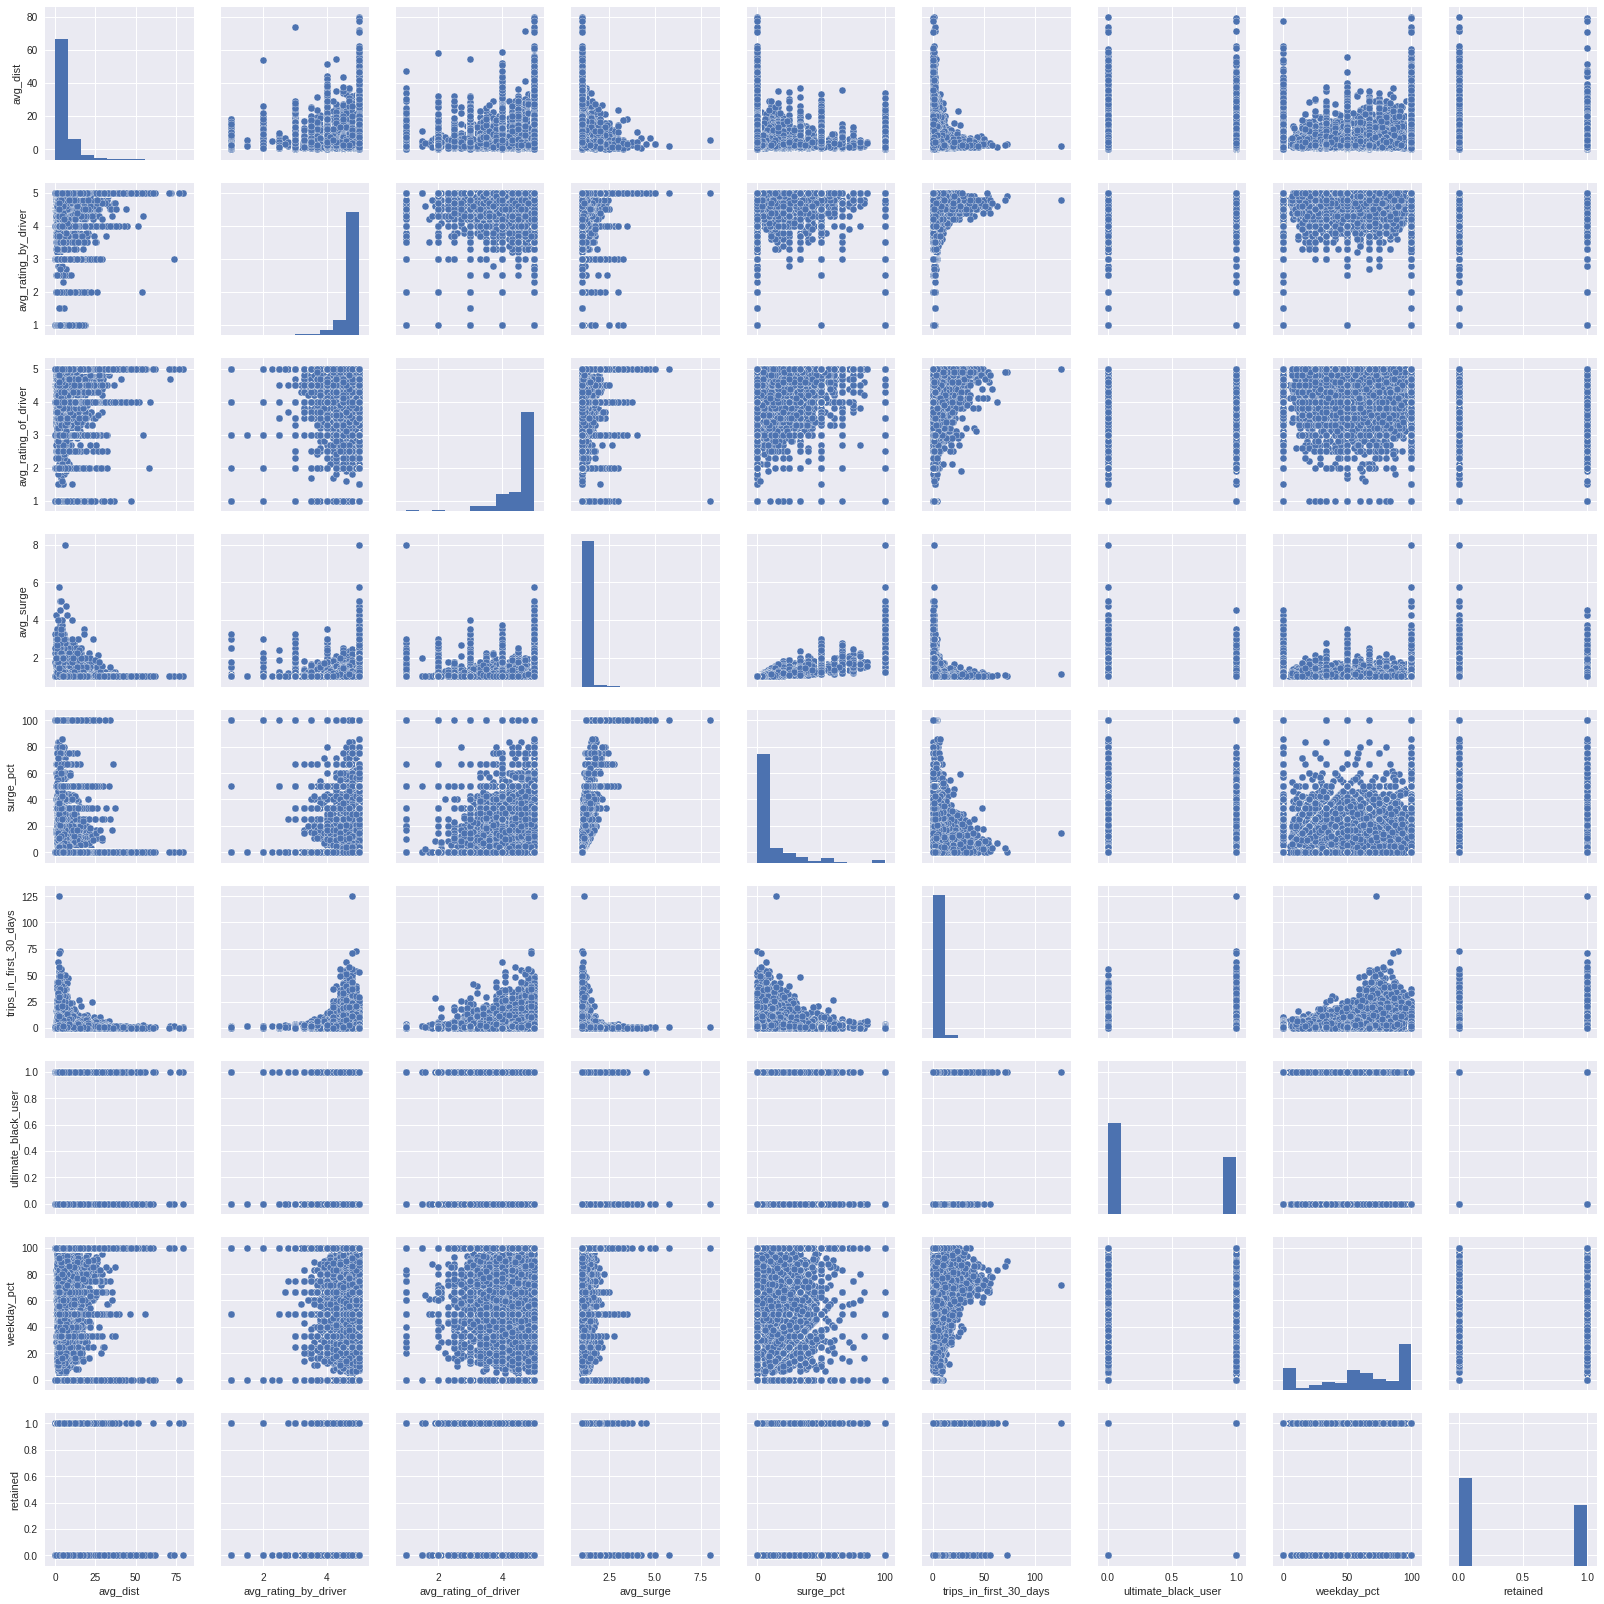

In [95]:
sns.pairplot(predictDF4[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'city', 'phone', 'signup_date', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'retained']], dropna=True, )

From the above pair plot we can see the distribution of each of the continous and ordinal feature (and target). Most of the features have skewed distribution or multimodal ones (those along the diagonal). The relationship between the features could be tracked by looking at the scatter plots. Average distance reveals a positive correlation with average ratings while it correlates negatively with surge values and trips on the first 30 days. The 100% of trips with a surge multiplier is an outlier (surge_pct). The percent of weekday trips histogram depicts a 3 modal histogram and each of those groups should be considered separately. We can create new columns based on the information above. Especially if a logistic linear regression model is going to be applied.

# Prediction model and feature importance

There are several indepedent variables that are skewed or with several modes in the histogram (average distance, average ratings, weekday percent) while others are categorical (phone, city). To apply a linear regression mode the categorical variables must be hot encoded and the multimode variables also transformed to one or more other variables. SVM classifiers do not have an in-built capability to reveal the independent variables importance. In this excercise I am using XGBoost classifier to create a predictive model and also analyze variable importance.

In [96]:
from xgboost import XGBClassifier, plot_importance

/home/kliton/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First we hot encode the phone predictor:

In [97]:
IsAndroidSeries = predictDF4.phone.apply(lambda x: (1 if x == 'Android' else 0) )
predictDF4.loc[:, 'IsAndroid'] = IsAndroidSeries

/home/kliton/.local/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/kliton/.local/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Also, it is required to hot encode the city predictor. There are 3 cities: Winterfell, Astapor and King's Landing. 

In [98]:
predictDF4.loc[:, 'IsWinterfell'] = predictDF4.city.apply(lambda x: 1 if x == 'Winterfell' else 0)
predictDF4.loc[:, 'IsAstapor'] = predictDF4.city.apply(lambda x: 1 if x == 'Astapor' else 0)

/home/kliton/.local/lib/python3.5/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/kliton/.local/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
# copy the newly created columns above
retainedDF = predictDF4[predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']]
nretainedDF = predictDF4[~predictDF4.retained][['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid', 'retained']].head(len(retainedDF))
combinedDF = retainedDF.append(nretainedDF)

Let's create XGBoost classifier and fit the model:

In [100]:
xgb = XGBClassifier()

After fitting the model we can take a look at the feature's importance by plotting it:

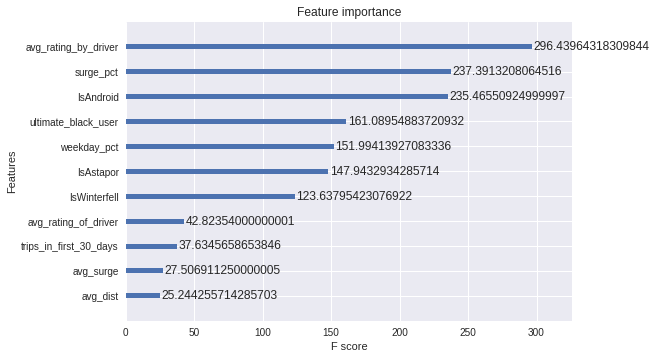

In [102]:
xgb.fit(predictDF4[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid']], predictDF4.retained.values)
plot_importance(xgb, importance_type='gain')

In [104]:
from sklearn.metrics import roc_auc_score
roc_auc_score(xgb.predict(predictDF4[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',  'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'IsAstapor', 'IsWinterfell', 'IsAndroid']]), 
              predictDF4.retained.values)

0.77517718611708453

And also apply the same procedure for the combined classes (same number of records for both classes):

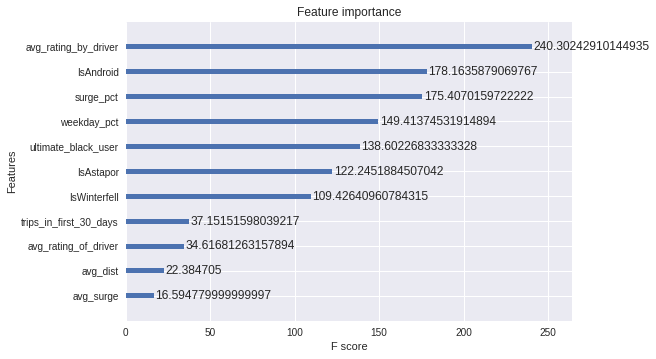

In [105]:
xgb.fit(combinedDF.drop('retained', axis=1), combinedDF.retained.values)
plot_importance(xgb, importance_type='gain')

In [106]:
roc_auc_score(xgb.predict(combinedDF.drop('retained', axis=1)), combinedDF.retained.values)

0.77660802364419446

There is no big difference between the unbalanced and combined datasets when training XGBoost classifier. The combined datasets gives slightly better result (larger value of area under ROC-curve), but that is not significant. In both cases we are using the same dataset for training and testing. The normal procedure is to cross validate the parameters of the models and tune them and then test the performance on a test set that has not been included in training. 

The factor importance is not changed significantly when using different datasets.

# Results and recommendations

From XGBoost it results that the most important factors predicting the retained customers are:
 - the average rating by driver: a higher score by driver, the highest are the chances to retain a passenger
 - the phone type of the person: Android users seem to have the lowest level of retained passengers probably due to worse user experience
 - average surge price, when surge price goes over 50% the passengers start to leave the service
 - percent of weekday trips, the passengers that tend to have a 100% of weekday trips have higher probability to drop the service. 
 - level of the luxury (ULTIMATE BLACK)
 - city where a passenger lives (Winterfell has the most percentage of retained passengers)
 
The ratio between the retained and the churn is 1:2. To avoid the bias caused by the imbalanced sets we undersampled the churn class. The impact of undersampling did not affect the factor importance ranking. The factor importance was the almost the same even for an imbalanced dataset.